In [3]:
import pandas as pd
import os

# List of Excel files (Ensure these files are in the same directory)
file_list = [
    "2017-2018 Champions League Stats.xlsx",
    "2018-2019 Champions League Stats.xlsx",
    "2019-2020 Champions League Stats.xlsx",
    "2020-2021 Champions League Stats.xlsx",
    "2021-2022 Champions League Stats.xlsx",
    "2022-2023 Champions League Stats.xlsx",
    "2023-2024 Champions League Stats.xlsx"
]

dataframes = []

for filename in file_list:
    try:
        # 1. Read without header to dynamically find the 'Rk' (Rank) row
        temp_df = pd.read_excel(filename, header=None)

        # Find the row index where the first cell is 'Rk'
        header_row_index = temp_df[temp_df[0] == 'Rk'].index[0]

        # 2. Reload the dataframe with the correct header
        df = pd.read_excel(filename, header=header_row_index)

        # 3. Data Cleaning
        # Remove rows where 'Rk' is not numeric (e.g., group headers like "Group A")
        df = df[pd.to_numeric(df['Rk'], errors='coerce').notna()].copy()

        # Add Season column
        season = filename.split(" ")[0]
        df['Season'] = season

        # 4. Feature Engineering & Type Conversion
        # Ensure key columns are numeric for calculation and future analysis
        # Note: 'Value' is crucial for the regression analysis later
        cols_to_numeric = ['Eliminated', 'Eliminating', 'Score', 'Value', 'Pts', 'xGD/90']

        for col in cols_to_numeric:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Fill NaN values with 0 (safe assumption for missing stats)
        df.fillna(0, inplace=True)

        # 5. Calculate Target Variable: Success_Score (Formerly 'Tur_Basarisi')
        # Formula: (5 * Eliminated) + (2 * Eliminating) - Score
        if 'Score' in df.columns:
            df['Success_Score'] = (5 * df['Eliminated']) + (2 * df['Eliminating']) - df['Score']
        else:
            # Fallback if Score column is missing
            df['Success_Score'] = (5 * df['Eliminated']) + (2 * df['Eliminating'])

        dataframes.append(df)
        print(f"Success: {filename} loaded.")

    except Exception as e:
        print(f"Error loading {filename}: {e}")

# Merge all years into one dataset
if dataframes:
    full_data = pd.concat(dataframes, ignore_index=True)
    print(f"\nProcessing Complete. Total rows merged: {len(full_data)}")

    # Save the cleaned data to a new Excel file
    output_filename = "Champions_League_All_Years_Cleaned.xlsx"
    full_data.to_excel(output_filename, index=False)
    print(f"File saved as: {output_filename}")

Success: 2017-2018 Champions League Stats.xlsx loaded.
Success: 2018-2019 Champions League Stats.xlsx loaded.
Success: 2019-2020 Champions League Stats.xlsx loaded.
Success: 2020-2021 Champions League Stats.xlsx loaded.
Success: 2021-2022 Champions League Stats.xlsx loaded.
Success: 2022-2023 Champions League Stats.xlsx loaded.
Success: 2023-2024 Champions League Stats.xlsx loaded.

Processing Complete. Total rows merged: 224
File saved as: Champions_League_All_Years_Cleaned.xlsx


--------------------------------------------------
Filtering:
Initial number of team: 224
Final number of team: 112
(Eliminated=0) : 112
--------------------------------------------------


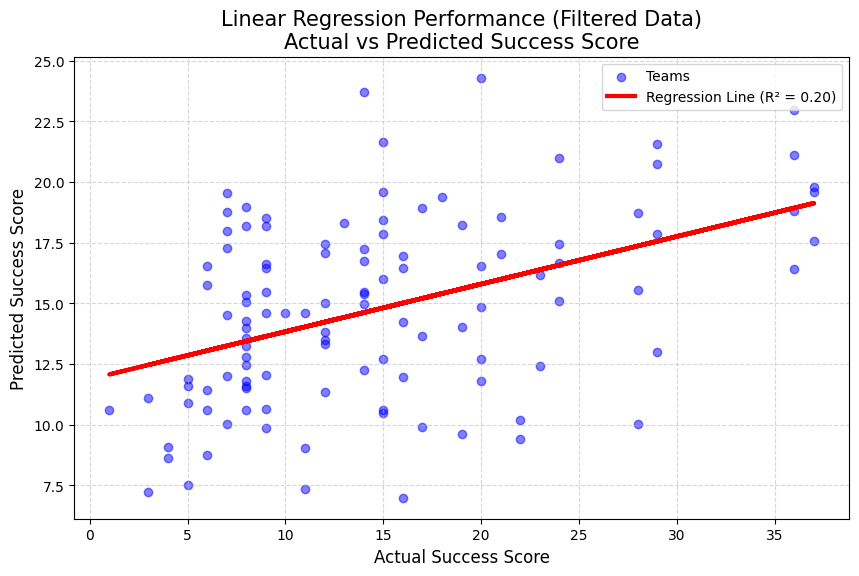

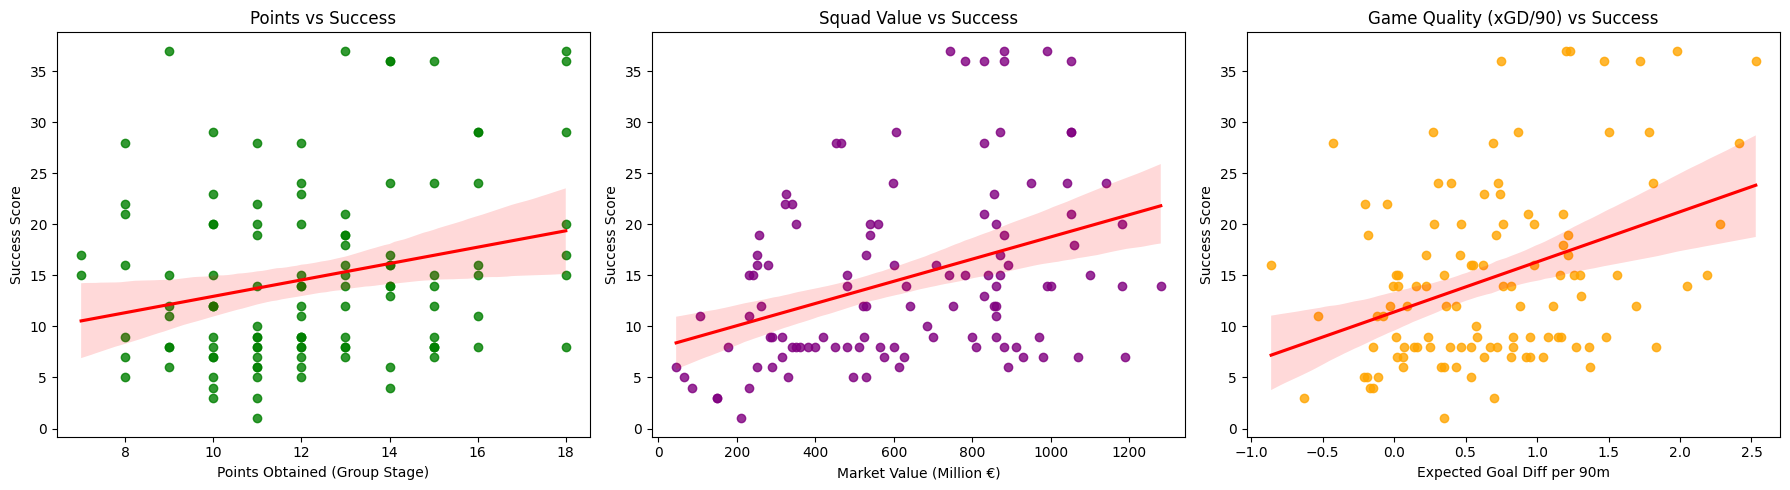


--------------------------------------------------
📌 MATHEMATICAL FORMULA (FILTERED DATA)
--------------------------------------------------
Success_Score = 6.46
               + (0.14794 * Pts)
               + (0.00698 * Value)
               + (3.03857 * xGD/90)
--------------------------------------------------


/tmp/ipython-input-2041028722.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


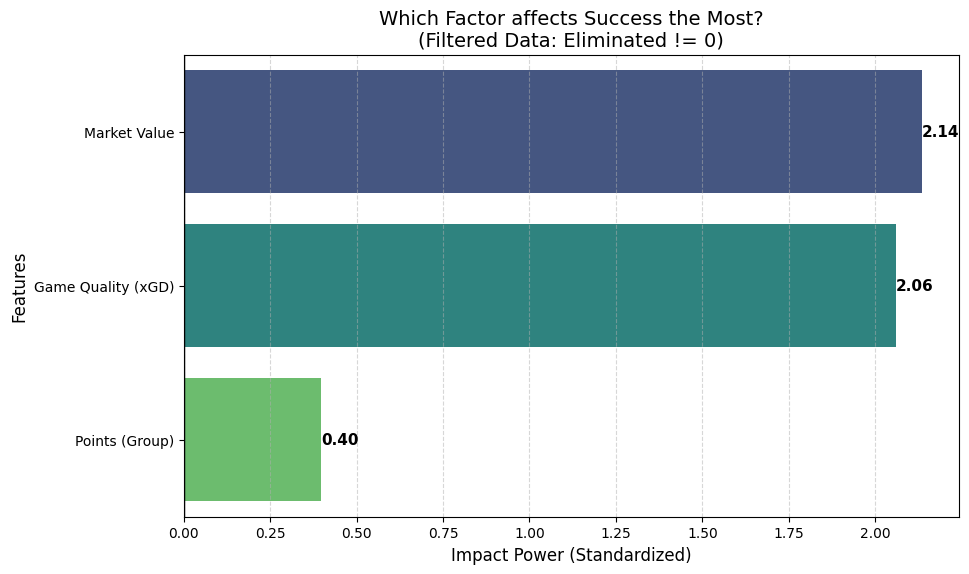

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# 1. DATA PREPARATION
# Önce ana verinin kopyasını alıyoruz
df_graph = full_data.copy()

# --- FİLTRELEME ADIMI ---
# 'eliminated' değeri 0 olanları veri setinden çıkarıyoruz.
# Sadece 0 olmayanlar (yani != 0) kalıyor.
if 'Eliminated' in df_graph.columns:
    initial_count = len(df_graph)
    df_graph = df_graph[df_graph['Eliminated'] != 0]
    final_count = len(df_graph)
    print("-" * 50)
    print(f"Filtering:")
    print(f"Initial number of team: {initial_count}")
    print(f"Final number of team: {final_count}")
    print(f"(Eliminated=0) : {initial_count - final_count}")
    print("-" * 50)
else:
    print("UYARI: 'eliminated' sütunu bulunamadı, filtreleme yapılmadı!")

# Features (Model Girdileri)
features = ['Pts', 'Value', 'xGD/90']
X = df_graph[features]

# Target Variable (Model Hedefi)
y = df_graph['Success_Score']

# 2. MODEL EĞİTİMİ (Grafik Çizimi İçin)
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

# R2 Skorunu Hesapla
r2 = r2_score(y, predictions)

# -------------------------------------------------------
# PLOT 1: OVERALL MODEL PERFORMANCE (ACTUAL vs PREDICTED)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# Scatter plot (Takımlar)
plt.scatter(y, predictions, color='blue', alpha=0.5, label='Teams')

# Regresyon Çizgisi (Kırmızı Çizgi)
m, b = np.polyfit(y, predictions, 1)
plt.plot(y, m*y + b, color='red', linewidth=3, label=f'Regression Line (R² = {r2:.2f})')

plt.title('Linear Regression Performance (Filtered Data)\nActual vs Predicted Success Score', fontsize=15)
plt.xlabel('Actual Success Score', fontsize=12)
plt.ylabel('Predicted Success Score', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------------------------------
# PLOT 2: INDIVIDUAL FEATURE IMPACT (SIMPLE LINEAR REGRESSION)
# -------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Pts vs Success
sns.regplot(x='Pts', y='Success_Score', data=df_graph, ax=axes[0], color='green', line_kws={'color':'red'})
axes[0].set_title('Points vs Success')
axes[0].set_xlabel('Points Obtained (Group Stage)')
axes[0].set_ylabel('Success Score')

# 2. Market Value vs Success
sns.regplot(x='Value', y='Success_Score', data=df_graph, ax=axes[1], color='purple', line_kws={'color':'red'})
axes[1].set_title('Squad Value vs Success')
axes[1].set_xlabel('Market Value (Million €)')
axes[1].set_ylabel('Success Score')

# 3. xGD/90 vs Success
sns.regplot(x='xGD/90', y='Success_Score', data=df_graph, ax=axes[2], color='orange', line_kws={'color':'red'})
axes[2].set_title('Game Quality (xGD/90) vs Success')
axes[2].set_xlabel('Expected Goal Diff per 90m')
axes[2].set_ylabel('Success Score')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# PART A: THE MATHEMATICAL FORMULA (Raw Coefficients)
# ---------------------------------------------------------
model_raw = LinearRegression()
model_raw.fit(X, y)

intercept = model_raw.intercept_
coefs = model_raw.coef_

print("\n" + "-" * 50)
print("📌 MATHEMATICAL FORMULA (FILTERED DATA)")
print("-" * 50)
print(f"Success_Score = {intercept:.2f}")
for i, feature in enumerate(features):
    sign = "+" if coefs[i] >= 0 else ""
    print(f"               {sign} ({coefs[i]:.5f} * {feature})")
print("-" * 50)

# ---------------------------------------------------------
# PART B: FEATURE IMPORTANCE (Standardized Coefficients)
# ---------------------------------------------------------
# Veriyi ölçeklendiriyoruz (Standartlaştırma)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Modeli ölçekli veriyle eğitiyoruz
model_scaled = LinearRegression()
model_scaled.fit(X_scaled_df, y)

# Katsayıları alıyoruz
importance_df = pd.DataFrame({
    'Feature': ['Points (Group)', 'Market Value', 'Game Quality (xGD)'],
    'Importance': model_scaled.coef_
})

# Sıralama (Büyükten küçüğe)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# ---------------------------------------------------------
# PLOT: STANDARDIZED FEATURE IMPORTANCE
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title('Which Factor affects Success the Most?\n(Filtered Data: Eliminated != 0)', fontsize=14)
plt.xlabel('Impact Power (Standardized)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Çubukların ucuna değerleri yazdır
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=11, fontweight='bold')

plt.show()

------------------------------------------------------------
🧹 DATA CLEANING REPORT
------------------------------------------------------------
Total Rows Before Filter : 224
Total Rows After Filter  : 112
Rows Dropped (Eliminated=0): 112
------------------------------------------------------------


/tmp/ipython-input-754400507.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


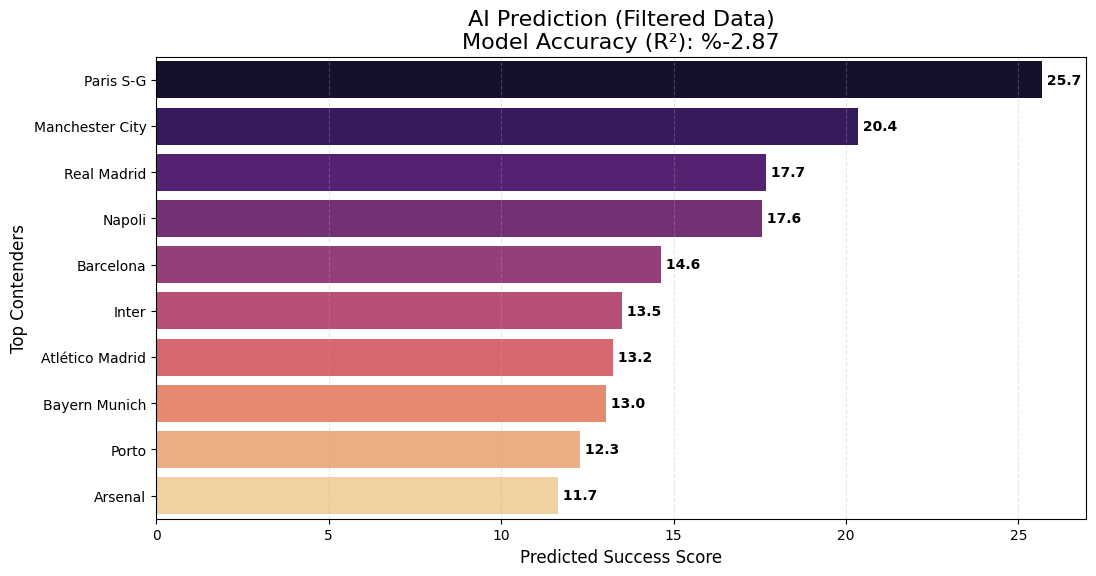

/tmp/ipython-input-754400507.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


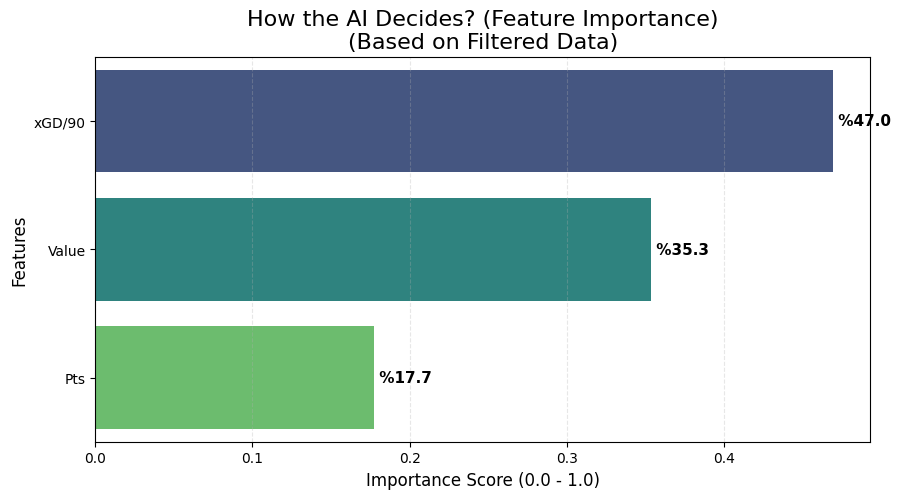

------------------------------------------------------------
🧠 AI ANALYSIS REPORT (FILTERED DATA)
------------------------------------------------------------
Prediction Accuracy (R²): %-2.87
------------------------------------------------------------
FEATURE IMPORTANCE RANKING:
👉 xGD/90         : %46.96
👉 Value          : %35.33
👉 Pts            : %17.71
------------------------------------------------------------
INTERPRETATION:
⚽ The model suggests: QUALITY OF PLAY (xGD) is what really matters.
------------------------------------------------------------


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. DATA PREPARATION & FILTERING
# Ana veriyi kopyala
df_rf = full_data.copy()

# --- FILTERING STEP ---
# Remove teams where eliminated is 0
if 'Eliminated' in df_rf.columns:
    initial_count = len(df_rf)
    df_rf = df_rf[df_rf['Eliminated'] != 0]
    final_count = len(df_rf)

    print("-" * 60)
    print("🧹 DATA CLEANING REPORT")
    print("-" * 60)
    print(f"Total Rows Before Filter : {initial_count}")
    print(f"Total Rows After Filter  : {final_count}")
    print(f"Rows Dropped (Eliminated=0): {initial_count - final_count}")
    print("-" * 60)
else:
    print("WARNING: 'eliminated' column not found. No filtering applied.")

# 2. TIME MACHINE SPLIT (Train: Past, Test: 2023-2024)
features = ['Pts', 'Value', 'xGD/90']

train_data = df_rf[df_rf['Season'] != '2023-2024'].copy()
test_data = df_rf[df_rf['Season'] == '2023-2024'].copy()

# Güvenlik önlemi: Eğer filtreleme sonrası 2023-2024 verisi kalmadıysa son sezonu al
if len(test_data) == 0:
    print("⚠️ WARNING: 2023-2024 data missing after filtering. Using the latest available season.")
    last_season = df_rf['Season'].max()
    test_data = df_rf[df_rf['Season'] == last_season].copy()
    train_data = df_rf[df_rf['Season'] != last_season].copy()

# 3. TRAIN RANDOM FOREST MODEL
X_train = train_data[features]
y_train = train_data['Success_Score']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. PREDICT & EVALUATE
X_test = test_data[features]
y_test_actual = test_data['Success_Score']

# Tahmin yap
test_data['Predicted_Score'] = rf_model.predict(X_test)
prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

# Sıralama (En yüksek tahmin edilen ilk 10)
champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

# =======================================================
# PLOT 1: PREDICTION RANKING (Filtered Data)
# =======================================================
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Predicted_Score',
    y='Squad',
    data=champions_prediction,
    palette='magma'
)
plt.title(f'AI Prediction (Filtered Data)\nModel Accuracy (R²): %{prediction_r2*100:.2f}', fontsize=16)
plt.xlabel('Predicted Success Score', fontsize=12)
plt.ylabel('Top Contenders', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Değerleri çubuklara yaz
for index, value in enumerate(champions_prediction['Predicted_Score']):
    plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

plt.show()

# =======================================================
# PLOT 2: FEATURE IMPORTANCE (Filtered Data)
# =======================================================
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('How the AI Decides? (Feature Importance)\n(Based on Filtered Data)', fontsize=16)
plt.xlabel('Importance Score (0.0 - 1.0)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f' %{value*100:.1f}', va='center', fontweight='bold', fontsize=11)

plt.show()

# =======================================================
# CONSOLE REPORT
# =======================================================
print("-" * 60)
print("🧠 AI ANALYSIS REPORT (FILTERED DATA)")
print("-" * 60)
print(f"Prediction Accuracy (R²): %{prediction_r2*100:.2f}")
print("-" * 60)
print("FEATURE IMPORTANCE RANKING:")
for index, row in feature_importance_df.iterrows():
    print(f"👉 {row['Feature']:<15}: %{row['Importance']*100:.2f}")
print("-" * 60)

# Yorumlama Mantığı
top_feature = feature_importance_df.iloc[0]['Feature']
print("INTERPRETATION:")
if top_feature == 'Value':
    print("💰 The model suggests: MONEY is the biggest factor for success.")
elif top_feature == 'Pts':
    print("📈 The model suggests: GROUP PERFORMANCE (Points) is the key filter.")
    print("   (Teams with low group points rarely succeed in knockout stages.)")
elif top_feature == 'xGD/90':
    print("⚽ The model suggests: QUALITY OF PLAY (xGD) is what really matters.")
print("-" * 60)

🧹 Veri Temizliği: 224 satırdan 112 satıra düştü.


/tmp/ipython-input-2281080226.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


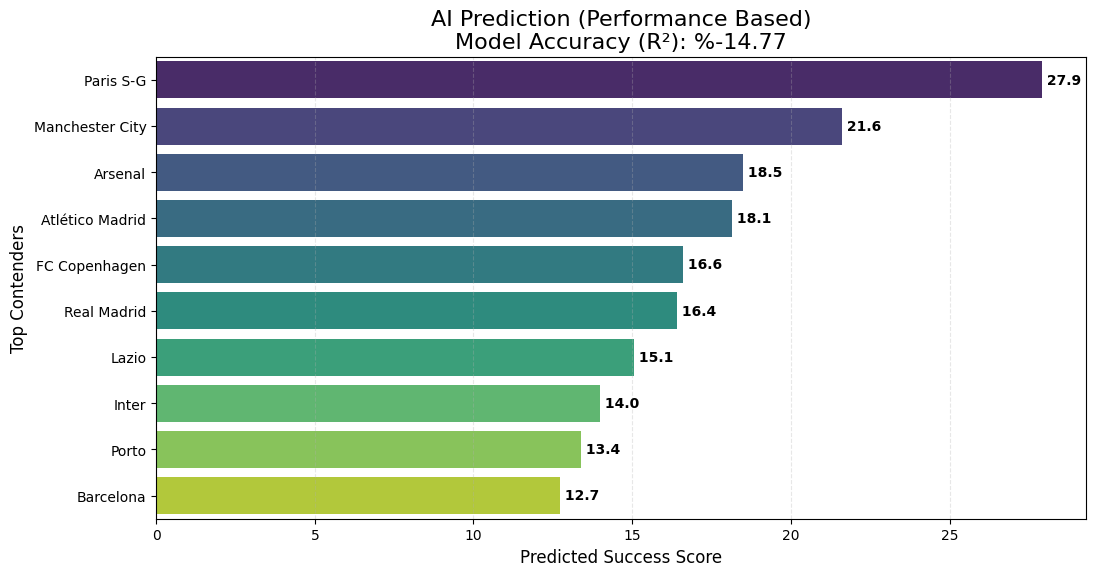

/tmp/ipython-input-2281080226.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


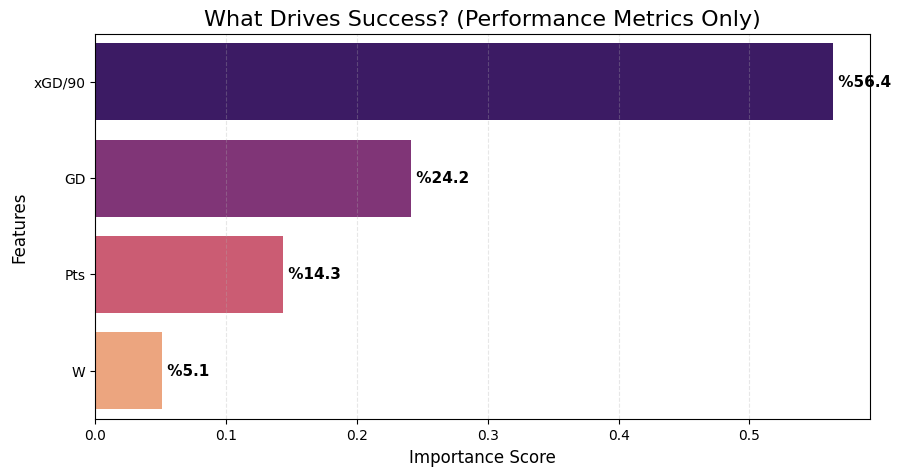

------------------------------------------------------------
📊 MODEL ANALİZ RAPORU (SADECE PERFORMANS)
------------------------------------------------------------
Model Doğruluğu (R²): %-14.77
------------------------------------------------------------
ETKİ SIRALAMASI:
👉 xGD/90    : %56.42
👉 GD        : %24.16
👉 Pts       : %14.34
👉 W         : %5.08
------------------------------------------------------------


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. VERİ HAZIRLIĞI & FİLTRELEME
df_rf = full_data.copy()

# --- FILTERING: Eliminated 0 olanları at ---
if 'Eliminated' in df_rf.columns:
    initial_count = len(df_rf)
    df_rf = df_rf[df_rf['Eliminated'] != 0]
    final_count = len(df_rf)
    print(f"🧹 Veri Temizliği: {initial_count} satırdan {final_count} satıra düştü.")
else:
    print("UYARI: 'eliminated' sütunu bulunamadı.")

# 2. YENİ ÖZELLİK SETİ (SAHA İÇİ PERFORMANS)
# Artık para (Value) yok. Sadece skorlar ve istatistikler var.
features = ['W', 'GD', 'Pts', 'xGD/90']

# Zaman Makinesi Mantığı (Geçmişle eğit, 2023-2024'ü tahmin et)
train_data = df_rf[df_rf['Season'] != '2023-2024'].copy()
test_data = df_rf[df_rf['Season'] == '2023-2024'].copy()

# Güvenlik Kontrolü
if len(test_data) == 0:
    print("UYARI: 2023-2024 verisi yok, son sezon test için kullanılıyor.")
    last_season = df_rf['Season'].max()
    test_data = df_rf[df_rf['Season'] == last_season].copy()
    train_data = df_rf[df_rf['Season'] != last_season].copy()

# 3. MODEL EĞİTİMİ (Random Forest)
X_train = train_data[features]
y_train = train_data['Success_Score']

# n_estimators=200 yaparak ormanı biraz daha büyüttük (daha hassas olması için)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# 4. TAHMİN VE DEĞERLENDİRME
X_test = test_data[features]
y_test_actual = test_data['Success_Score']

test_data['Predicted_Score'] = rf_model.predict(X_test)
prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

# Sıralama
champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

# =======================================================
# GRAFİK 1: TAHMİN SIRALAMASI
# =======================================================
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Predicted_Score',
    y='Squad',
    data=champions_prediction,
    palette='viridis'
)
plt.title(f'AI Prediction (Performance Based)\nModel Accuracy (R²): %{prediction_r2*100:.2f}', fontsize=16)
plt.xlabel('Predicted Success Score', fontsize=12)
plt.ylabel('Top Contenders', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(champions_prediction['Predicted_Score']):
    plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

plt.show()

# =======================================================
# GRAFİK 2: ÖZELLİK ÖNEMİ (HANGİ İSTATİSTİK KRAL?)
# =======================================================
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='magma'
)

plt.title('What Drives Success? (Performance Metrics Only)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f' %{value*100:.1f}', va='center', fontweight='bold', fontsize=11)

plt.show()

# =======================================================
# KONSOL RAPORU
# =======================================================
print("-" * 60)
print("📊 MODEL ANALİZ RAPORU (SADECE PERFORMANS)")
print("-" * 60)
print(f"Model Doğruluğu (R²): %{prediction_r2*100:.2f}")
print("-" * 60)
print("ETKİ SIRALAMASI:")
for index, row in feature_importance_df.iterrows():
    print(f"👉 {row['Feature']:<10}: %{row['Importance']*100:.2f}")
print("-" * 60)

🧹 TEMİZLİK YAPILDI: 112 takım çıkarıldı. Analiz 112 takım ile yapılıyor.


/tmp/ipython-input-4151222545.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


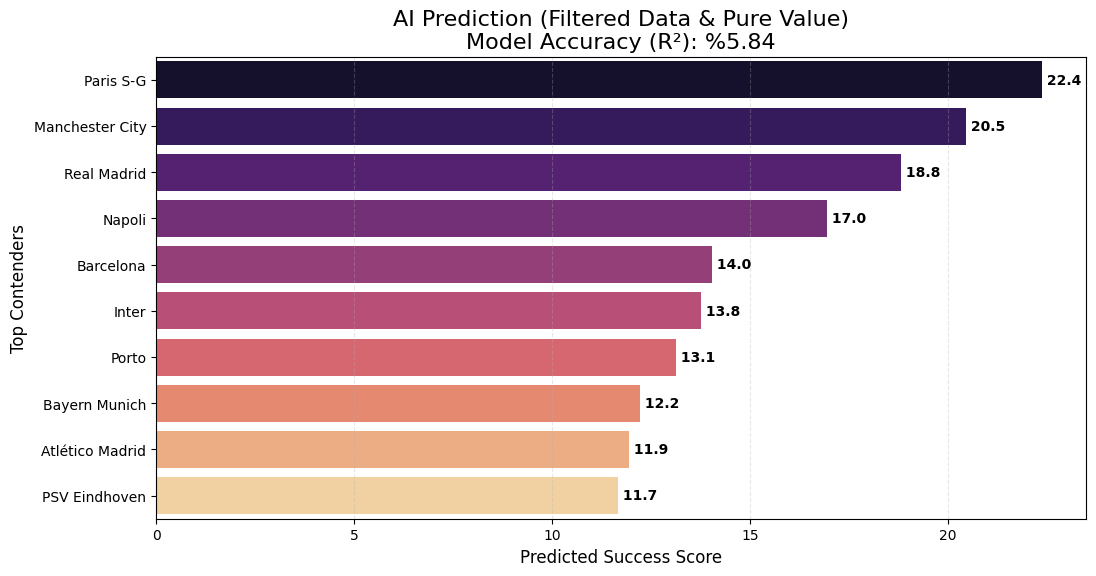

/tmp/ipython-input-4151222545.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


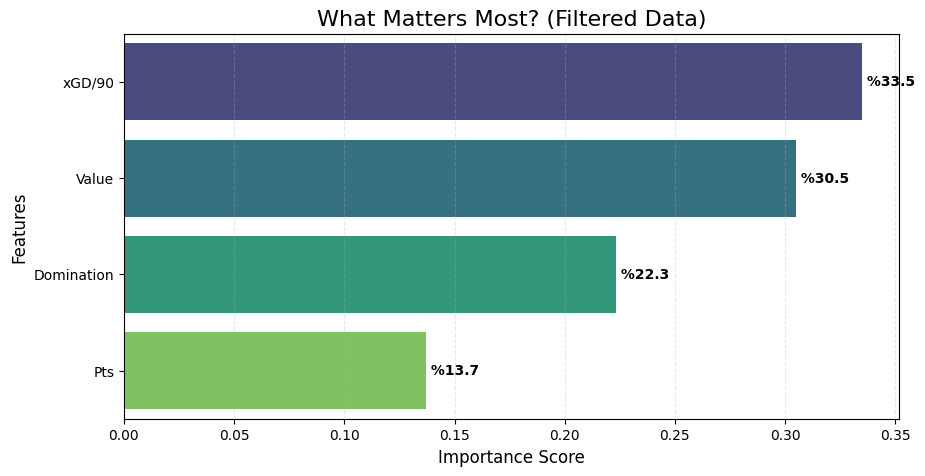

------------------------------------------------------------
✅ R² SKORU (FİLTRELİ): %5.84
------------------------------------------------------------
ÖZELLİK ÖNEM SIRALAMASI:
   Feature  Importance
    xGD/90    0.334868
     Value    0.304901
Domination    0.223119
       Pts    0.137112
------------------------------------------------------------


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. VERİ HAZIRLIĞI
df_final = full_data.copy()

# --- FİLTRELEME ADIMI (İsteğin Üzerine) ---
# Eliminated değeri 0 olanları (veya veri girişi olmayanları) atıyoruz.
if 'Eliminated' in df_final.columns:
    before = len(df_final)
    df_final = df_final[df_final['Eliminated'] != 0]
    after = len(df_final)
    print(f"🧹 TEMİZLİK YAPILDI: {before - after} takım çıkarıldı. Analiz {after} takım ile yapılıyor.")

# 2. FEATURE ENGINEERING
# Efficiency YOK. Direkt Value var.
# Ekstra olarak sadece Domination ekliyoruz (Fark yaratması için).

df_final['Domination'] = df_final['W'] * df_final['xGD/90']

# ÖZELLİK LİSTESİ
# Value: Para
# Pts: Grup Puanı
# xGD/90: Oyun Kalitesi
# Domination: Galibiyet ve Kalite sentezi
features = ['Value', 'Pts', 'xGD/90', 'Domination']

# 3. ZAMAN MAKİNESİ (Train/Test Split)
train_data = df_final[df_final['Season'] != '2023-2024'].copy()
test_data = df_final[df_final['Season'] == '2023-2024'].copy()

# Güvenlik önlemi (Filtreleme sonrası veri kalmazsa diye)
if len(test_data) == 0:
    print("UYARI: 2023-2024 verisi kalmadı, son mevcut sezon test için kullanılıyor.")
    last_season = df_final['Season'].max()
    test_data = df_final[df_final['Season'] == last_season].copy()
    train_data = df_final[df_final['Season'] != last_season].copy()

# 4. RANDOM FOREST EĞİTİMİ
X_train = train_data[features]
y_train = train_data['Success_Score']

# Modeli kuruyoruz
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# 5. TAHMİN
X_test = test_data[features]
y_test_actual = test_data['Success_Score']

test_data['Predicted_Score'] = rf_model.predict(X_test)
prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

# 6. GÖRSELLEŞTİRME
champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Predicted_Score',
    y='Squad',
    data=champions_prediction,
    palette='magma'
)
# Başlıkta Filtreli Veri olduğunu belirtiyoruz
plt.title(f'AI Prediction (Filtered Data & Pure Value)\nModel Accuracy (R²): %{prediction_r2*100:.2f}', fontsize=16)
plt.xlabel('Predicted Success Score', fontsize=12)
plt.ylabel('Top Contenders', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(champions_prediction['Predicted_Score']):
    plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

plt.show()

# 7. FEATURE IMPORTANCE
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)
plt.title('What Matters Most? (Filtered Data)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f' %{value*100:.1f}', va='center', fontweight='bold')

plt.show()

print("-" * 60)
print(f"✅ R² SKORU (FİLTRELİ): %{prediction_r2*100:.2f}")
print("-" * 60)
print("ÖZELLİK ÖNEM SIRALAMASI:")
print(feature_importance_df.to_string(index=False))
print("-" * 60)

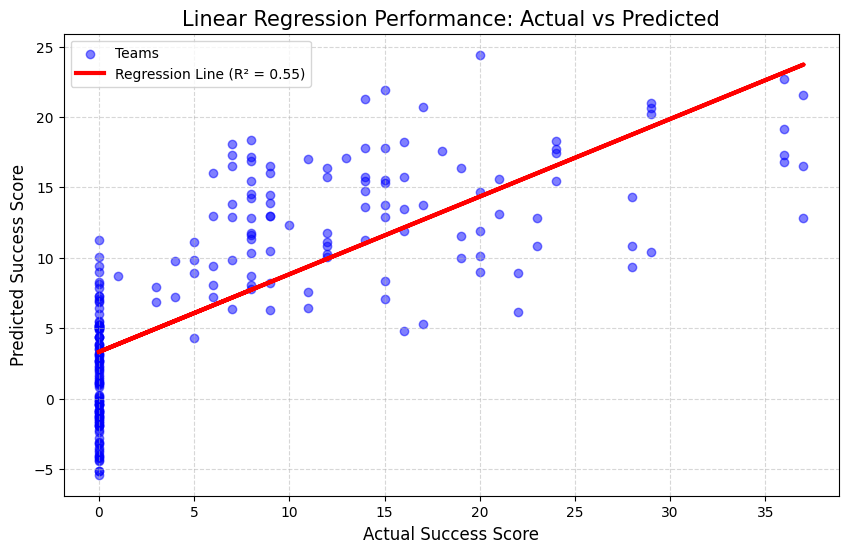

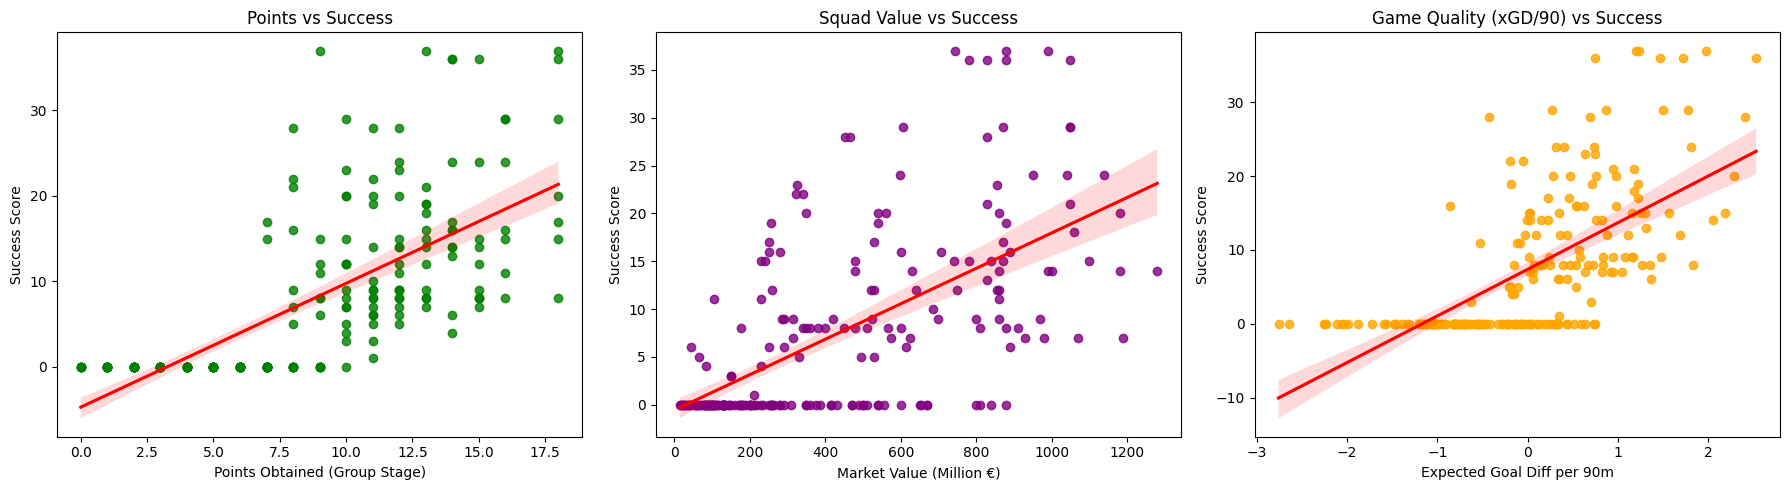

--------------------------------------------------
📌 MATHEMATICAL FORMULA (LINEAR REGRESSION MODEL)
--------------------------------------------------
Success_Score = -2.97
               + (0.88340 * Pts)
               + (0.00691 * Value)
               + (1.46405 * xGD/90)
--------------------------------------------------
NOTE: 'Value' coefficient might look small because 1 Million Euro is a huge unit.
--------------------------------------------------


/tmp/ipython-input-3786137823.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


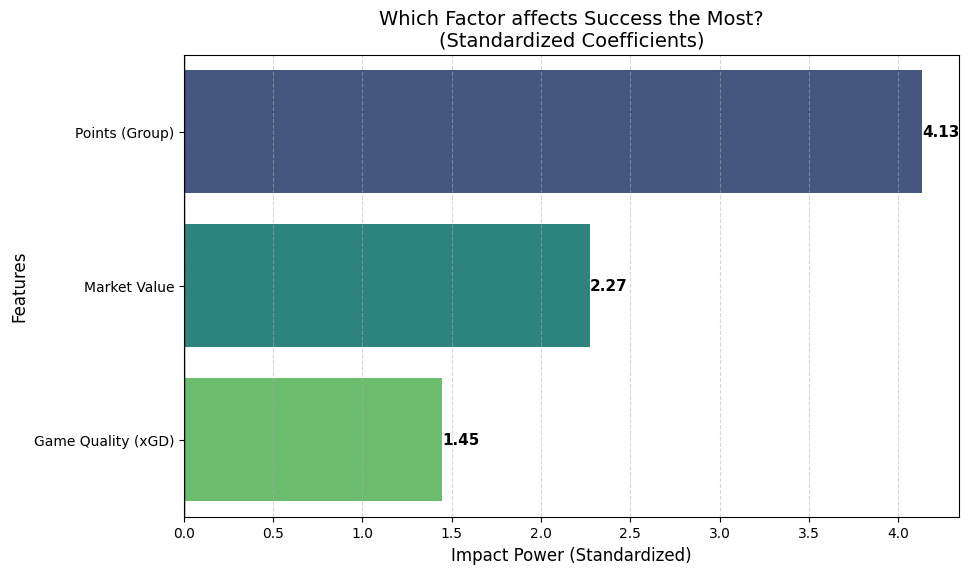

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. DATA PREPARATION
# using full_data from the previous step
df_graph = full_data.copy()

# Features (Using original column names from the Excel files)
features = ['Pts', 'Value', 'xGD/90']
X = df_graph[features]

# Target Variable (Created in the previous cleaning step)
y = df_graph['Success_Score']

# Train Model (For plotting purposes)
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

# Calculate R2 Score
r2 = r2_score(y, predictions)

# -------------------------------------------------------
# PLOT 1: OVERALL MODEL PERFORMANCE (ACTUAL vs PREDICTED)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# Scatter plot (Teams)
plt.scatter(y, predictions, color='blue', alpha=0.5, label='Teams')

# Perfect Prediction Line (Red Line)
m, b = np.polyfit(y, predictions, 1)
plt.plot(y, m*y + b, color='red', linewidth=3, label=f'Regression Line (R² = {r2:.2f})')

plt.title('Linear Regression Performance: Actual vs Predicted', fontsize=15)
plt.xlabel('Actual Success Score', fontsize=12)
plt.ylabel('Predicted Success Score', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------------------------------
# PLOT 2: INDIVIDUAL FEATURE IMPACT (SIMPLE LINEAR REGRESSION)
# -------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Plot: Points vs Success
# Note: 'Pts' is the column name in the data, 'Points' is the label for the graph
sns.regplot(x='Pts', y='Success_Score', data=df_graph, ax=axes[0], color='green', line_kws={'color':'red'})
axes[0].set_title('Points vs Success')
axes[0].set_xlabel('Points Obtained (Group Stage)')
axes[0].set_ylabel('Success Score')

# 2. Plot: Market Value vs Success
sns.regplot(x='Value', y='Success_Score', data=df_graph, ax=axes[1], color='purple', line_kws={'color':'red'})
axes[1].set_title('Squad Value vs Success')
axes[1].set_xlabel('Market Value (Million €)')
axes[1].set_ylabel('Success Score')

# 3. Plot: xGD/90 vs Success
sns.regplot(x='xGD/90', y='Success_Score', data=df_graph, ax=axes[2], color='orange', line_kws={'color':'red'})
axes[2].set_title('Game Quality (xGD/90) vs Success')
axes[2].set_xlabel('Expected Goal Diff per 90m')
axes[2].set_ylabel('Success Score')

plt.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 1. PREPARE DATA
features = ['Pts', 'Value', 'xGD/90']
X = df_graph[features]
y = df_graph['Success_Score']

# ---------------------------------------------------------
# PART A: THE MATHEMATICAL FORMULA (Raw Coefficients)
# ---------------------------------------------------------
# We fit the model on raw data to get the real-world formula
model_raw = LinearRegression()
model_raw.fit(X, y)

intercept = model_raw.intercept_
coefs = model_raw.coef_

print("-" * 50)
print("📌 MATHEMATICAL FORMULA (LINEAR REGRESSION MODEL)")
print("-" * 50)
print(f"Success_Score = {intercept:.2f}")
for i, feature in enumerate(features):
    sign = "+" if coefs[i] >= 0 else ""
    print(f"               {sign} ({coefs[i]:.5f} * {feature})")
print("-" * 50)
print("NOTE: 'Value' coefficient might look small because 1 Million Euro is a huge unit.")
print("-" * 50)

# ---------------------------------------------------------
# PART B: FEATURE IMPORTANCE (Standardized Coefficients)
# ---------------------------------------------------------
# We scale the data so all variables compete on equal terms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Fit model on scaled data
model_scaled = LinearRegression()
model_scaled.fit(X_scaled_df, y)

# Get standardized coefficients
importance_df = pd.DataFrame({
    'Feature': ['Points (Group)', 'Market Value', 'Game Quality (xGD)'],
    'Importance': model_scaled.coef_
})

# Sort for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# ---------------------------------------------------------
# PLOT: STANDARDIZED FEATURE IMPORTANCE
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title('Which Factor affects Success the Most?\n(Standardized Coefficients)', fontsize=14)
plt.xlabel('Impact Power (Standardized)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add values to the end of bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=11, fontweight='bold')

plt.show()

Temizlik sonrası analiz edilen takım sayısı: 224


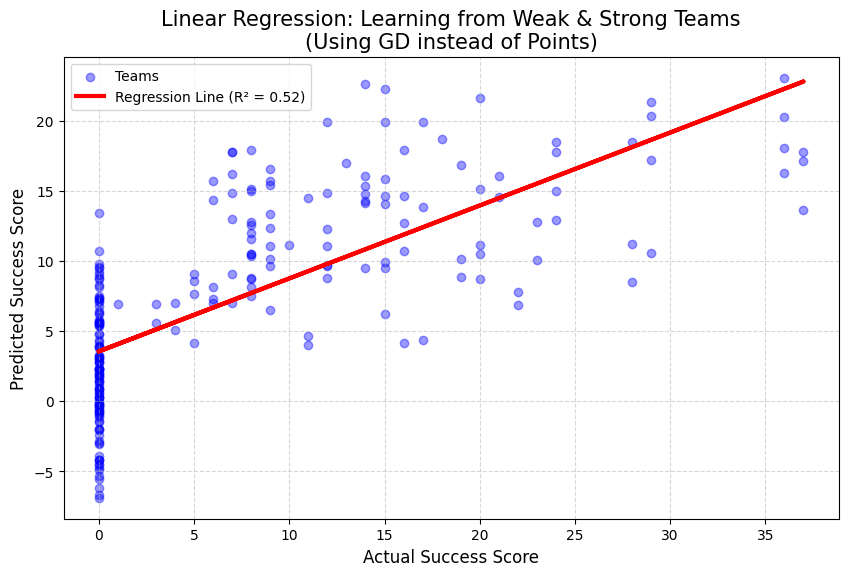

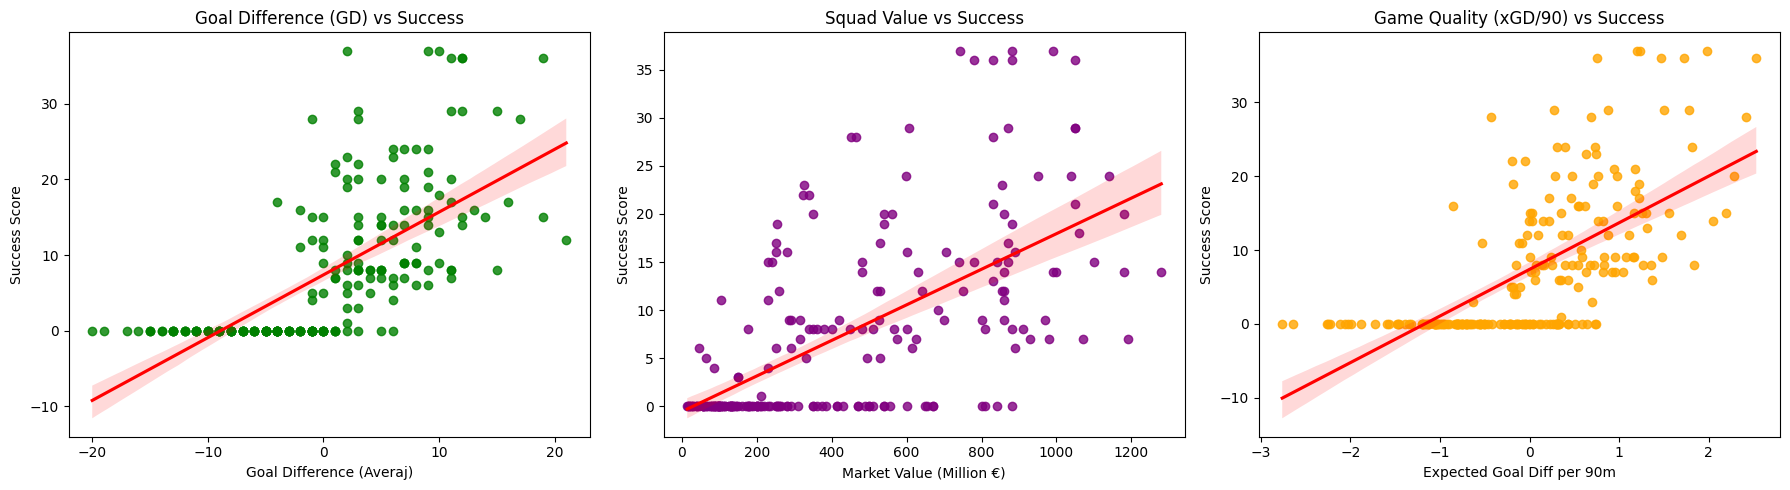

--------------------------------------------------
📌 FORMULA OF SUCCESS (Without Points)
--------------------------------------------------
Success_Score = 3.82
               + (0.45277 * GD)
               + (0.00830 * Value)
               + (1.31454 * xGD/90)
--------------------------------------------------


/tmp/ipython-input-1943497888.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


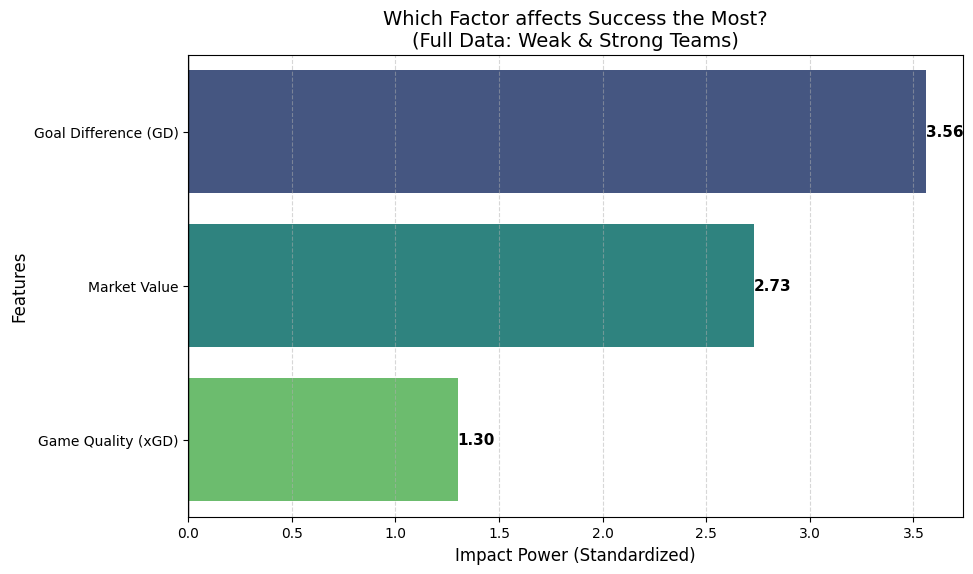

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# 1. DATA PREPARATION & CLEANING (HATA DÜZELTME KISMI)
df_graph = full_data.copy()

# --- KRİTİK DÜZELTME ---
# Pandas'ın sayı sandığımız şeyleri yazı (string) olarak görmesini engelliyoruz.
# errors='coerce' komutu, sayıya çevrilemeyen (mesela '-' gibi) değerleri NaN (boş) yapar.
cols_to_fix = ['GD', 'Value', 'xGD/90', 'Success_Score']

for col in cols_to_fix:
    if col in df_graph.columns:
        df_graph[col] = pd.to_numeric(df_graph[col], errors='coerce')

# Sayıya çevirince 'NaN' (Boş) olan satırları atıyoruz (Grafiği bozmamaları için)
df_graph = df_graph.dropna(subset=cols_to_fix)

print(f"Temizlik sonrası analiz edilen takım sayısı: {len(df_graph)}")

# Features (Pts yerine GD kullanıyoruz)
features = ['GD', 'Value', 'xGD/90']
X = df_graph[features]
y = df_graph['Success_Score']

# 2. MODEL TRAINING
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

# R2 Score
r2 = r2_score(y, predictions)

# -------------------------------------------------------
# PLOT 1: OVERALL MODEL PERFORMANCE
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions, color='blue', alpha=0.4, label='Teams')

m, b = np.polyfit(y, predictions, 1)
plt.plot(y, m*y + b, color='red', linewidth=3, label=f'Regression Line (R² = {r2:.2f})')

plt.title('Linear Regression: Learning from Weak & Strong Teams\n(Using GD instead of Points)', fontsize=15)
plt.xlabel('Actual Success Score', fontsize=12)
plt.ylabel('Predicted Success Score', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------------------------------
# PLOT 2: INDIVIDUAL FEATURE IMPACT
# -------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. GD vs Success
sns.regplot(x='GD', y='Success_Score', data=df_graph, ax=axes[0], color='green', line_kws={'color':'red'})
axes[0].set_title('Goal Difference (GD) vs Success')
axes[0].set_xlabel('Goal Difference (Averaj)')
axes[0].set_ylabel('Success Score')

# 2. Value vs Success
sns.regplot(x='Value', y='Success_Score', data=df_graph, ax=axes[1], color='purple', line_kws={'color':'red'})
axes[1].set_title('Squad Value vs Success')
axes[1].set_xlabel('Market Value (Million €)')
axes[1].set_ylabel('Success Score')

# 3. xGD/90 vs Success
sns.regplot(x='xGD/90', y='Success_Score', data=df_graph, ax=axes[2], color='orange', line_kws={'color':'red'})
axes[2].set_title('Game Quality (xGD/90) vs Success')
axes[2].set_xlabel('Expected Goal Diff per 90m')
axes[2].set_ylabel('Success Score')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# PART A: THE MATHEMATICAL FORMULA
# ---------------------------------------------------------
intercept = model.intercept_
coefs = model.coef_

print("-" * 50)
print("📌 FORMULA OF SUCCESS (Without Points)")
print("-" * 50)
print(f"Success_Score = {intercept:.2f}")
for i, feature in enumerate(features):
    sign = "+" if coefs[i] >= 0 else ""
    print(f"               {sign} ({coefs[i]:.5f} * {feature})")
print("-" * 50)

# ---------------------------------------------------------
# PART B: FEATURE IMPORTANCE (Standardized)
# ---------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

model_scaled = LinearRegression()
model_scaled.fit(X_scaled_df, y)

importance_df = pd.DataFrame({
    'Feature': ['Goal Difference (GD)', 'Market Value', 'Game Quality (xGD)'],
    'Importance': model_scaled.coef_
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title('Which Factor affects Success the Most?\n(Full Data: Weak & Strong Teams)', fontsize=14)
plt.xlabel('Impact Power (Standardized)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)

for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=11, fontweight='bold')

plt.show()

--------------------------------------------------
🌲 RANDOM FOREST MODEL PERFORMANCE (Week 9)
--------------------------------------------------
R² Score: %50.78
Comment: If this score is higher than Linear Regression,
it means there are non-linear relationships in football data.
--------------------------------------------------


/tmp/ipython-input-3454376179.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


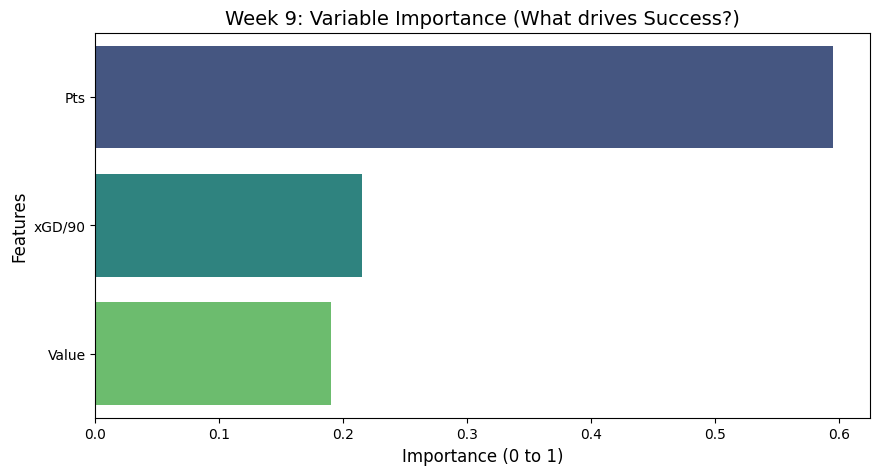

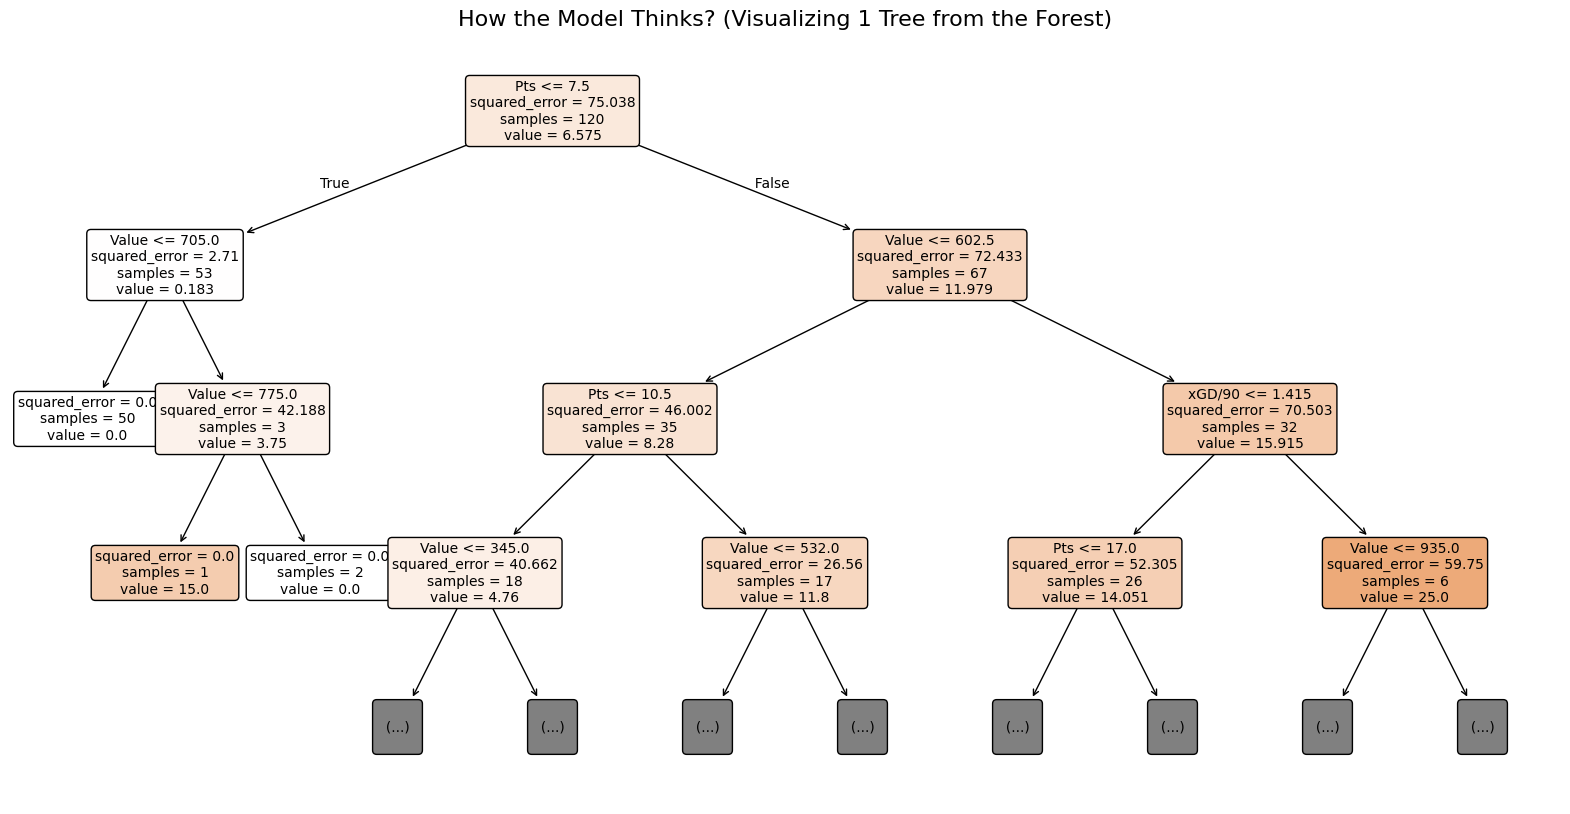

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 1. VERİ HAZIRLIĞI
# full_data hafızada yüklü olmalı
df_week9 = full_data.copy()

# DÜZELTME BURADA: 'Market_Value' yerine orijinal isim 'Value' kullanıyoruz.
features = ['Pts', 'Value', 'xGD/90']
X = df_week9[features]
y = df_week9['Success_Score']

# Eğitim ve Test Ayrımı (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. RANDOM FOREST MODELİ (Week 9 - Slayt 19)
# n_estimators=100: 100 tane karar ağacı oluşturur
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

# Tahmin ve Skor
y_pred = rf_model.predict(X_test)
r2_val = r2_score(y_test, y_pred)

print("-" * 50)
print(f"🌲 RANDOM FOREST MODEL PERFORMANCE (Week 9)")
print("-" * 50)
print(f"R² Score: %{r2_val*100:.2f}")
print("Comment: If this score is higher than Linear Regression,")
print("it means there are non-linear relationships in football data.")
print("-" * 50)

# -------------------------------------------------------
# GRAPH 1: FEATURE IMPORTANCE (Slayt 21)
# -------------------------------------------------------
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Week 9: Variable Importance (What drives Success?)', fontsize=14)
plt.xlabel('Importance (0 to 1)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

# -------------------------------------------------------
# GRAPH 2: VISUALIZING A TREE
# -------------------------------------------------------
plt.figure(figsize=(20, 10))
# Ormandaki ilk ağacı çizelim
plot_tree(rf_model.estimators_[0],
          feature_names=features,
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=10)
plt.title('How the Model Thinks? (Visualizing 1 Tree from the Forest)', fontsize=16)
plt.show()

/tmp/ipython-input-3890750287.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


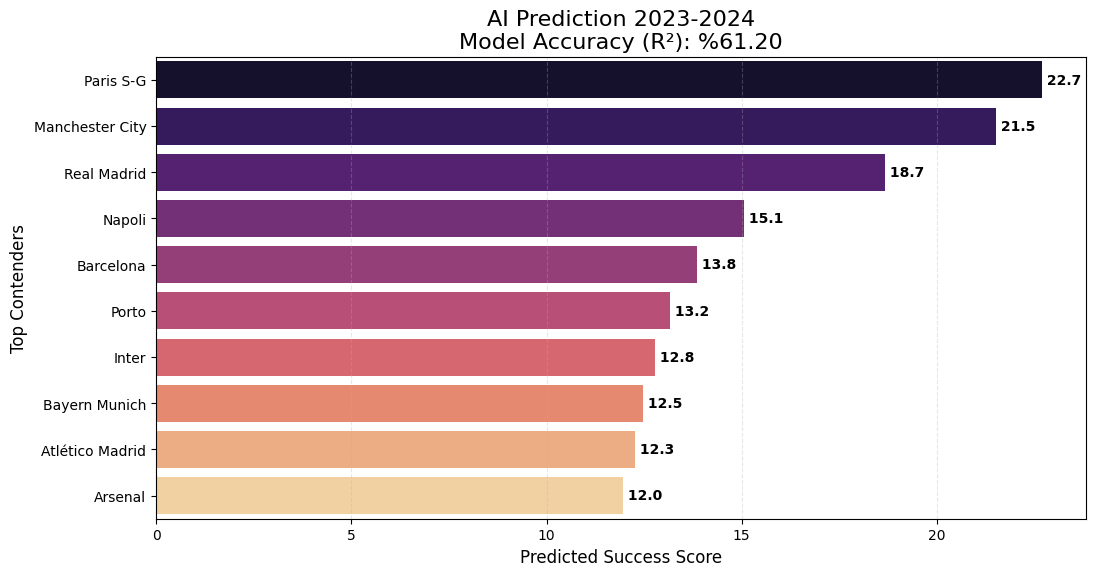

/tmp/ipython-input-3890750287.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


------------------------------------------------------------
📊 MODEL VALIDATION REPORT (2023-2024 TEST SET)
------------------------------------------------------------
Prediction Accuracy (R²): %61.20
------------------------------------------------------------
INTERPRETATION:
⚠️ The model is MODERATE. 2024 had some surprises/outliers.
------------------------------------------------------------


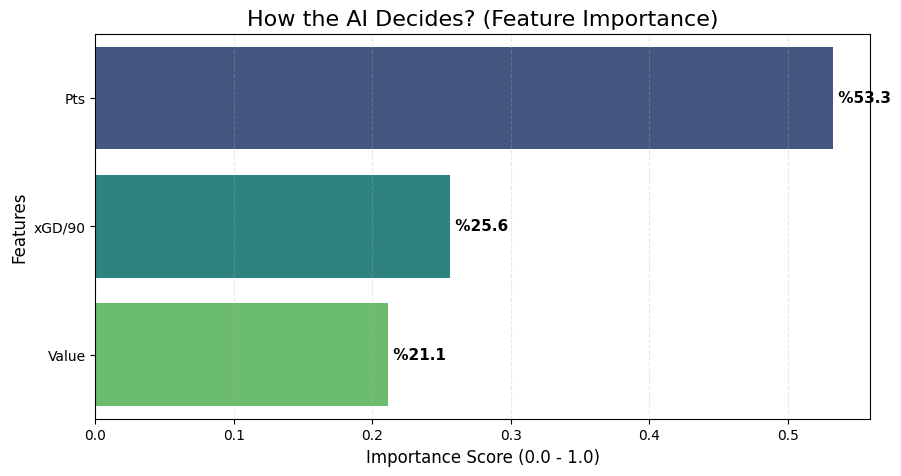

------------------------------------------------------------
🧠 AI BRAIN SCAN: WHAT MATTERS MOST?
------------------------------------------------------------
👉 Pts       : %53.29
👉 xGD/90    : %25.58
👉 Value     : %21.13
------------------------------------------------------------
INTERPRETATION:
📈 FORM IS TEMPORARY, CLASS IS PERMANENT: Group stage points are the main indicator.
------------------------------------------------------------


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# 1. DATA PREPARATION (TIME MACHINE LOGIC)
# Train on past (2017-2023), Predict future (2023-2024)
features = ['Pts', 'Value', 'xGD/90']

# Split Data
train_data = full_data[full_data['Season'] != '2023-2024'].copy()
test_data = full_data[full_data['Season'] == '2023-2024'].copy()

if len(test_data) == 0:
    print("WARNING: 2023-2024 data missing. Using the latest season instead.")
    last_season = full_data['Season'].max()
    test_data = full_data[full_data['Season'] == last_season].copy()
    train_data = full_data[full_data['Season'] != last_season].copy()

# 2. TRAIN THE MODEL
X_train = train_data[features]
y_train = train_data['Success_Score']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. PREDICT & EVALUATE (THE MISSING PIECE)
X_test = test_data[features]
y_test_actual = test_data['Success_Score']  # The REAL results of 2023-2024

# Make predictions
test_data['Predicted_Score'] = rf_model.predict(X_test)

# CALCULATE R2 SCORE FOR THE PREDICTION
prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

# 4. RANKING
champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

# -------------------------------------------------------
# VISUALIZATION WITH ACCURACY METRIC
# -------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Predicted_Score',
    y='Squad',
    data=champions_prediction,
    palette='magma'
)

# Title now includes the Accuracy Score
plt.title(f'AI Prediction 2023-2024\nModel Accuracy (R²): %{prediction_r2*100:.2f}', fontsize=16)
plt.xlabel('Predicted Success Score', fontsize=12)
plt.ylabel('Top Contenders', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(champions_prediction['Predicted_Score']):
    plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

plt.show()

# -------------------------------------------------------
# PERFORMANCE REPORT
# -------------------------------------------------------
print("-" * 60)
print("📊 MODEL VALIDATION REPORT (2023-2024 TEST SET)")
print("-" * 60)
print(f"Prediction Accuracy (R²): %{prediction_r2*100:.2f}")
print("-" * 60)
print("INTERPRETATION:")
if prediction_r2 > 0.70:
    print("✅ The model is HIGHLY ACCURATE. The past rules apply well to 2024.")
elif prediction_r2 > 0.40:
    print("⚠️ The model is MODERATE. 2024 had some surprises/outliers.")
else:
    print("❌ The model struggled. 2024 was a very chaotic/unpredictable season.")
print("-" * 60)


importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# -------------------------------------------------------
# PLOT 2: FEATURE IMPORTANCE GRAPH
# -------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('How the AI Decides? (Feature Importance)', fontsize=16)
plt.xlabel('Importance Score (0.0 - 1.0)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Çubukların ucuna yüzde değerlerini yazalım
for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f' %{value*100:.1f}', va='center', fontweight='bold', fontsize=11)

plt.show()

# -------------------------------------------------------
# CONSOLE REPORT
# -------------------------------------------------------
print("-" * 60)
print("🧠 AI BRAIN SCAN: WHAT MATTERS MOST?")
print("-" * 60)
for index, row in feature_importance_df.iterrows():
    print(f"👉 {row['Feature']:<10}: %{row['Importance']*100:.2f}")
print("-" * 60)
print("INTERPRETATION:")
top_feature = feature_importance_df.iloc[0]['Feature']
if top_feature == 'Value':
    print("💰 MONEY TALKS: The model thinks Market Value is the #1 key to winning.")
elif top_feature == 'xGD/90':
    print("⚽ QUALITY MATTERS: The model prioritizes strong gameplay (xGD) over money.")
elif top_feature == 'Pts':
    print("📈 FORM IS TEMPORARY, CLASS IS PERMANENT: Group stage points are the main indicator.")
print("-" * 60)

/tmp/ipython-input-1869639272.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


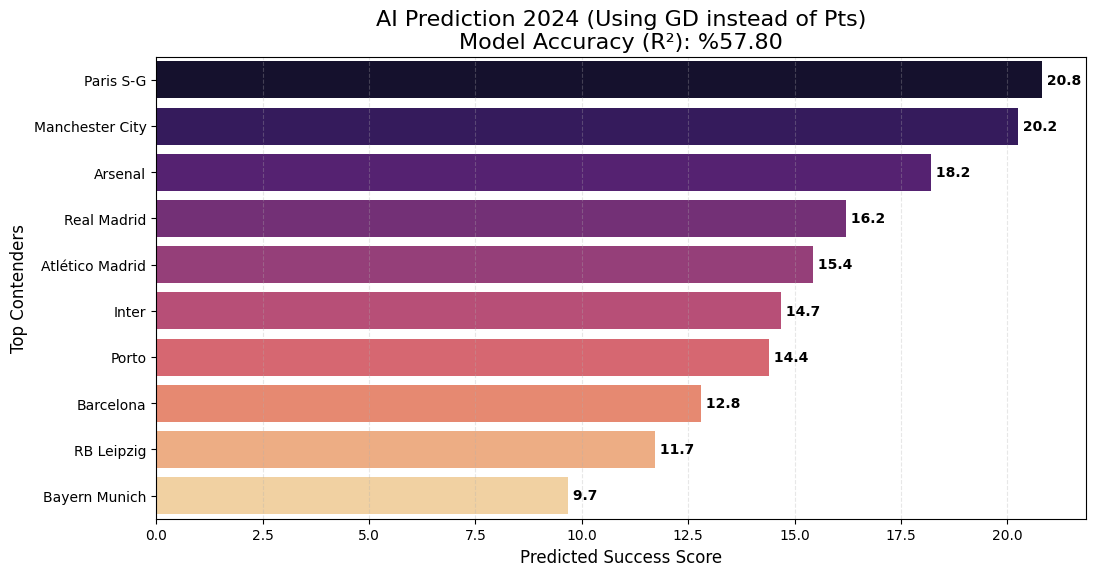

/tmp/ipython-input-1869639272.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


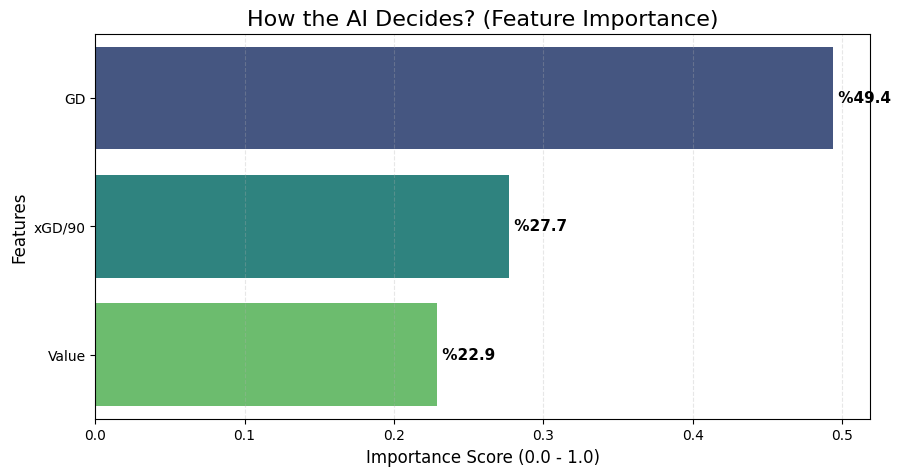

------------------------------------------------------------
🧠 AI BRAIN SCAN: WHAT MATTERS MOST?
------------------------------------------------------------
👉 GD        : %49.42
👉 xGD/90    : %27.71
👉 Value     : %22.87
------------------------------------------------------------
INTERPRETATION:
🥅 SCOREBOARD DOMINANCE: The model says 'Goal Difference' is the best predictor.
   (Teams that crush their opponents in groups usually win the trophy.)
------------------------------------------------------------
Prediction Error (RMSE): 6.35


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_error

# 1. DATA CLEANING & PREPARATION
# Önce ana veriyi kopyalayalım
df_rf = full_data.copy()

# KRİTİK ADIM: 'GD' sütununu sayıya çeviriyoruz (Excel'den yazı olarak geldiyse hata vermesin)
# 'coerce' komutu, sayı olmayan garip karakterleri (varsa) NaN (boş) yapar.
df_rf['GD'] = pd.to_numeric(df_rf['GD'], errors='coerce')

# Sayıya çevirince boş kalan (bozuk) satırları temizle
df_rf = df_rf.dropna(subset=['GD', 'Value', 'xGD/90', 'Success_Score'])

# 2. TIME MACHINE LOGIC
# Train on past (2017-2023), Predict future (2023-2024)
# Pts YERİNE ARTIK GD VAR!
features = ['GD', 'Value', 'xGD/90']

# Split Data
train_data = df_rf[df_rf['Season'] != '2023-2024'].copy()
test_data = df_rf[df_rf['Season'] == '2023-2024'].copy()

# Güvenlik önlemi: Eğer 23-24 verisi yoksa son sezonu test yap
if len(test_data) == 0:
    print("WARNING: 2023-2024 data missing. Using the latest season instead.")
    last_season = df_rf['Season'].max()
    test_data = df_rf[df_rf['Season'] == last_season].copy()
    train_data = df_rf[df_rf['Season'] != last_season].copy()

# 3. TRAIN THE MODEL (Random Forest)
X_train = train_data[features]
y_train = train_data['Success_Score']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. PREDICT & EVALUATE
X_test = test_data[features]
y_test_actual = test_data['Success_Score']

# Make predictions
test_data['Predicted_Score'] = rf_model.predict(X_test)

# CALCULATE R2 SCORE
prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

# 5. RANKING
champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

# -------------------------------------------------------
# PLOT 1: PREDICTION RANKING
# -------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Predicted_Score',
    y='Squad',
    data=champions_prediction,
    palette='magma'
)

plt.title(f'AI Prediction 2024 (Using GD instead of Pts)\nModel Accuracy (R²): %{prediction_r2*100:.2f}', fontsize=16)
plt.xlabel('Predicted Success Score', fontsize=12)
plt.ylabel('Top Contenders', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(champions_prediction['Predicted_Score']):
    plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

plt.show()

# -------------------------------------------------------
# PLOT 2: FEATURE IMPORTANCE GRAPH
# -------------------------------------------------------
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('How the AI Decides? (Feature Importance)', fontsize=16)
plt.xlabel('Importance Score (0.0 - 1.0)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f' %{value*100:.1f}', va='center', fontweight='bold', fontsize=11)

plt.show()

# -------------------------------------------------------
# CONSOLE REPORT
# -------------------------------------------------------
print("-" * 60)
print("🧠 AI BRAIN SCAN: WHAT MATTERS MOST?")
print("-" * 60)
for index, row in feature_importance_df.iterrows():
    print(f"👉 {row['Feature']:<10}: %{row['Importance']*100:.2f}")
print("-" * 60)

print("INTERPRETATION:")
top_feature = feature_importance_df.iloc[0]['Feature']

if top_feature == 'Value':
    print("💰 MONEY TALKS: The model thinks Market Value is the #1 key to winning.")
elif top_feature == 'xGD/90':
    print("⚽ QUALITY MATTERS: The model prioritizes strong gameplay (xGD) over money.")
elif top_feature == 'GD':
    print("🥅 SCOREBOARD DOMINANCE: The model says 'Goal Difference' is the best predictor.")
    print("   (Teams that crush their opponents in groups usually win the trophy.)")
print("-" * 60)

# CALCULATE RMSE (Week 9 Addition)
mse = mean_squared_error(y_test_actual, test_data['Predicted_Score'])
rmse = np.sqrt(mse)
print(f"Prediction Error (RMSE): {rmse:.2f}")

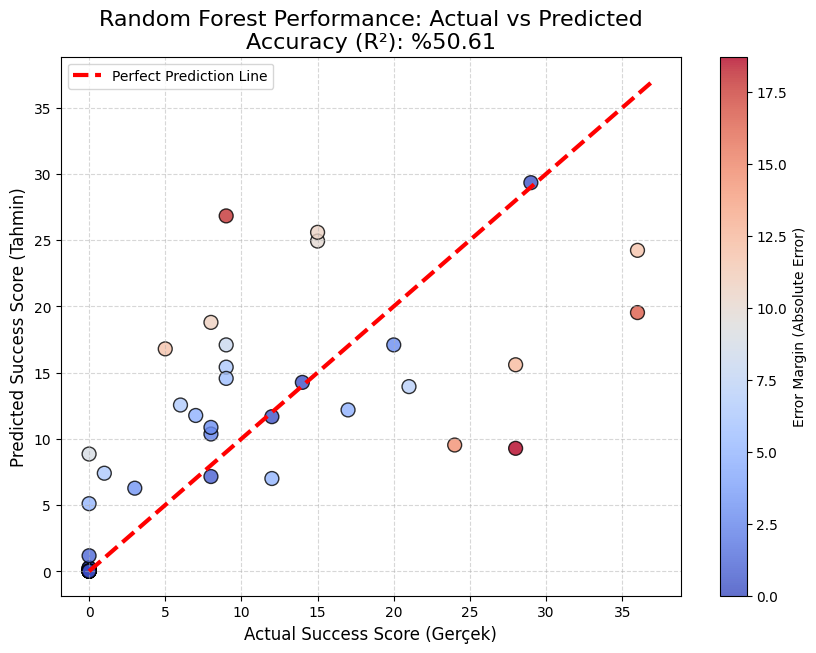

------------------------------------------------------------
GRAFİK YORUMU:
1. Kırmızı Kesikli Çizgi: Hedefimizdir. Noktalar bunun üstündeyse 'Tam İsabet'.
2. Mavi Noktalar: Tahminler. Çizgiye ne kadar yapışıksa model o kadar iyidir.
3. Kırmızıya Çalan Noktalar: Modelin en çok yanıldığı takımlar.
------------------------------------------------------------


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. VERİ HAZIRLIĞI
df_rf = full_data.copy()

# Temizlik (GD ve Value sayı olsun)
cols = ['GD', 'Value', 'xGD/90', 'Success_Score']
for col in cols:
    df_rf[col] = pd.to_numeric(df_rf[col], errors='coerce')
df_rf = df_rf.dropna(subset=cols)

# 2. MODELİ EĞİT (Tüm geçmiş verilerle)
features = ['GD', 'Value', 'xGD/90']
X = df_rf[features]
y = df_rf['Success_Score']

# Train/Test ayırımı (Grafik dürüst olsun diye rastgele %20'yi saklıyoruz)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# R2 Skoru
r2 = r2_score(y_test, predictions)

# -------------------------------------------------------
# GÖRSELLEŞTİRME: ACTUAL vs PREDICTED
# -------------------------------------------------------
plt.figure(figsize=(10, 7))

# 1. Gerçek vs Tahmin Noktaları
# Renkleri 'Hata Payına' göre ayarlayalım (Koyu renkler = Büyük hata)
errors = abs(y_test - predictions)
sc = plt.scatter(y_test, predictions, c=errors, cmap='coolwarm', s=100, alpha=0.8, edgecolor='k')

# 2. Mükemmel Tahmin Çizgisi (The Perfect Line)
# Bu çizgi y = x doğrusudur. Nokta bunun üstündeyse tahmin kusursuzdur.
min_val = min(y.min(), predictions.min())
max_val = max(y.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, label='Perfect Prediction Line')

# 3. Grafik Süslemeleri
plt.title(f'Random Forest Performance: Actual vs Predicted\nAccuracy (R²): %{r2*100:.2f}', fontsize=16)
plt.xlabel('Actual Success Score (Gerçek)', fontsize=12)
plt.ylabel('Predicted Success Score (Tahmin)', fontsize=12)
plt.colorbar(sc, label='Error Margin (Absolute Error)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 4. Önemli Takımları İşaretle (Opsiyonel - Rastgele birkaç tane)
# Bu kısım grafik üzerinde hangi noktanın hangi takım olduğunu görmek için
# (Kodun bu kısmı sadece örneklem için, tüm isimleri yazarsak karmaşa olur)
# İstersen silebilirsin.

plt.show()

print("-" * 60)
print("GRAFİK YORUMU:")
print("1. Kırmızı Kesikli Çizgi: Hedefimizdir. Noktalar bunun üstündeyse 'Tam İsabet'.")
print("2. Mavi Noktalar: Tahminler. Çizgiye ne kadar yapışıksa model o kadar iyidir.")
print("3. Kırmızıya Çalan Noktalar: Modelin en çok yanıldığı takımlar.")
print("-" * 60)

/tmp/ipython-input-3492361970.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipython-input-3492361970.py:55: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


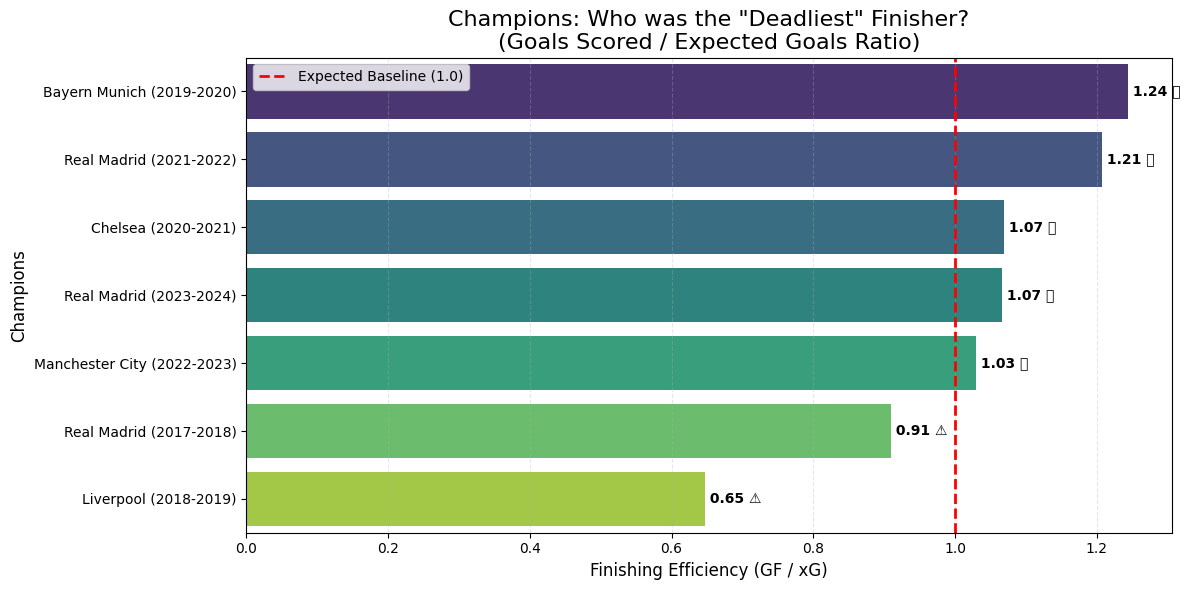

------------------------------------------------------------
🏆 ŞAMPİYONLARIN BİTİRİCİLİK KARNESİ (GF / xG)
------------------------------------------------------------
AÇIKLAMA:
 > 1.0 : İmkansızı başaranlar (Kaliteli ayaklar / Şans)
 = 1.0 : Hakkını verenler
 < 1.0 : Çok kaçırıp yine de şampiyon olanlar (Defansla kazananlar)
------------------------------------------------------------
   Season           Squad  GF   xG  Finishing_Efficiency
2019-2020   Bayern Munich  24 19.3              1.243523
2021-2022     Real Madrid  14 11.6              1.206897
2020-2021         Chelsea  14 13.1              1.068702
2023-2024     Real Madrid  16 15.0              1.066667
2022-2023 Manchester City  14 13.6              1.029412
2017-2018     Real Madrid  17 18.7              0.909091
2018-2019       Liverpool   9 13.9              0.647482
------------------------------------------------------------


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. VERİ HAZIRLIĞI
# Sadece Şampiyonları al (Eliminated == 5)
champions = full_data[full_data['Eliminated'] == 5].copy()

# Olası veri tipi hatalarını önlemek için sayıya çeviriyoruz
cols_to_convert = ['GF', 'xG']
for col in cols_to_convert:
    # Hata durumunda 'coerce' ile NaN yaparız, sonra doldururuz
    if col in champions.columns:
        champions[col] = pd.to_numeric(champions[col], errors='coerce')

# 2. METRİK HESAPLAMA: BITIRICILIK ORANI
# Eğer xG 0 ise bölme hatası olmasın diye küçük bir sayı ekleyebiliriz veya direkt böleriz.
# (Şampiyon takımın xG'si 0 olamaz ama tedbir iyidir)
champions['Finishing_Efficiency'] = champions['GF'] / champions['xG']

# Grafik için etiket (Takım Adı + Sezon)
champions['Label'] = champions['Squad'] + ' (' + champions['Season'] + ')'

# Veriyi orana göre sıralayalım (En keskin olandan en cömerte)
champions_sorted = champions.sort_values(by='Finishing_Efficiency', ascending=False)

# 3. GÖRSELLEŞTİRME
plt.figure(figsize=(12, 6))

# Renk paleti: 1.0'ın üstü (İyi bitiricilik) Yeşilimsi, Altı Kırmızımsı olsun diye 'vlag' veya 'coolwarm' kullanabiliriz
# Ama basit ve şık olması için 'viridis' kullanalım.
barplot = sns.barplot(
    x='Finishing_Efficiency',
    y='Label',
    data=champions_sorted,
    palette='viridis'
)

# REFERANS ÇİZGİSİ (1.0)
# Burası "Beklenen = Gerçekleşen" noktasıdır.
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Expected Baseline (1.0)')

plt.title('Champions: Who was the "Deadliest" Finisher?\n(Goals Scored / Expected Goals Ratio)', fontsize=16)
plt.xlabel('Finishing Efficiency (GF / xG)', fontsize=12)
plt.ylabel('Champions', fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Çubukların ucuna değerleri yazalım
for index, value in enumerate(champions_sorted['Finishing_Efficiency']):
    # Değer 1'den büyükse "Overperform", küçükse "Underperform"
    status = "🔥" if value > 1.0 else "⚠️"
    plt.text(value, index, f' {value:.2f} {status}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. KONSOL RAPORU
print("-" * 60)
print("🏆 ŞAMPİYONLARIN BİTİRİCİLİK KARNESİ (GF / xG)")
print("-" * 60)
print("AÇIKLAMA:")
print(" > 1.0 : İmkansızı başaranlar (Kaliteli ayaklar / Şans)")
print(" = 1.0 : Hakkını verenler")
print(" < 1.0 : Çok kaçırıp yine de şampiyon olanlar (Defansla kazananlar)")
print("-" * 60)
print(champions_sorted[['Season', 'Squad', 'GF', 'xG', 'Finishing_Efficiency']].to_string(index=False))
print("-" * 60)

/tmp/ipython-input-2772904383.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Efficiency', data=plot_data, palette='Set2', showmeans=True,


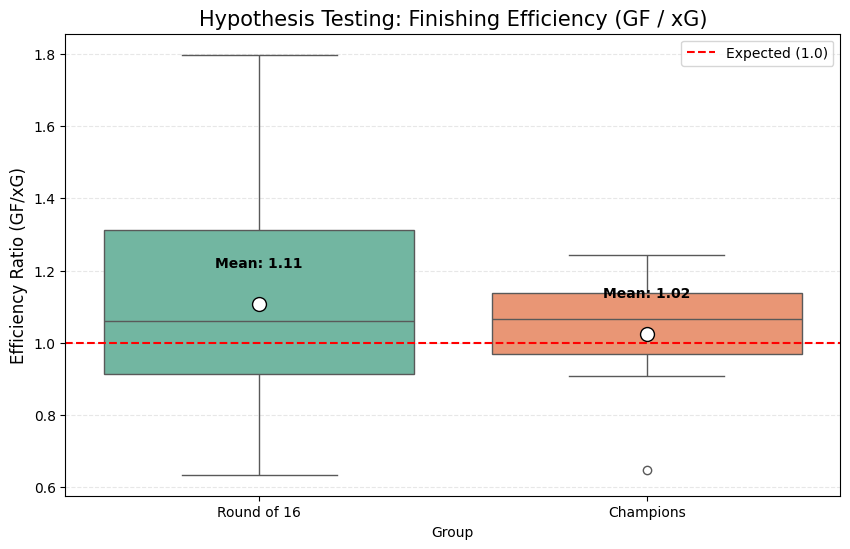

------------------------------------------------------------
🧪 HYPOTHESIS TESTING REPORT
------------------------------------------------------------
Grup R16 Ortalaması  : 1.109 (N=56)
Grup Champ Ortalaması: 1.025 (N=7)
------------------------------------------------------------
t-statistic: -0.9991
p-value    : 0.3434
------------------------------------------------------------
❌ SONUÇ: H0 REDDEDİLEMEDİ (Fail to Reject H0)
İstatistiksel olarak anlamlı bir fark BULUNAMADI.
Yorum: Şampiyonları şampiyon yapan şey 'Bitiricilik Becerisi' (Topu kaleye sokma yeteneği) değil.
Muhtemelen 'Pozisyon Yaratma Becerisi'dir (Daha çok xG üretmeleri).
------------------------------------------------------------


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. VERİ HAZIRLIĞI VE FİLTRELEME
df_ttest = full_data.copy()

# Sayısal dönüşüm (Garanti olsun diye)
cols_to_numeric = ['GF', 'xG']
for col in cols_to_numeric:
    df_ttest[col] = pd.to_numeric(df_ttest[col], errors='coerce')

# Oran Hesabı: Finishing Efficiency = GF / xG
# Sıfıra bölünme hatasını önlemek için xG=0 olanları atıyoruz (varsa)
df_ttest = df_ttest[df_ttest['xG'] > 0]
df_ttest['Efficiency'] = df_ttest['GF'] / df_ttest['xG']

# 2. GRUPLARI AYIRMA
# Grup 1: Son 16'da Elenenler (Eliminated = 1)
group_r16 = df_ttest[df_ttest['Eliminated'] == 1]['Efficiency'].dropna()

# Grup 2: Şampiyonlar (Eliminated = 5)
group_champ = df_ttest[df_ttest['Eliminated'] == 5]['Efficiency'].dropna()

# 3. İSTATİSTİKSEL TEST (Independent t-test)
# equal_var=False yapıyoruz (Welch's t-test) çünkü iki grubun varyansı ve eleman sayısı eşit olmayabilir.
# Bu yöntem daha güvenilirdir.
t_stat, p_value = stats.ttest_ind(group_champ, group_r16, equal_var=False)

# 4. GÖRSELLEŞTİRME (BOX PLOT)
# Veriyi görselleştirmek için birleştirelim
plot_data = pd.concat([
    pd.DataFrame({'Group': 'Round of 16', 'Efficiency': group_r16}),
    pd.DataFrame({'Group': 'Champions', 'Efficiency': group_champ})
])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Efficiency', data=plot_data, palette='Set2', showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"})

plt.title(f'Hypothesis Testing: Finishing Efficiency (GF / xG)', fontsize=15)
plt.ylabel('Efficiency Ratio (GF/xG)', fontsize=12)
plt.axhline(1.0, color='red', linestyle='--', label='Expected (1.0)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Ortalamaları yaz
mean_r16 = group_r16.mean()
mean_champ = group_champ.mean()
plt.text(0, mean_r16 + 0.1, f'Mean: {mean_r16:.2f}', ha='center', fontweight='bold')
plt.text(1, mean_champ + 0.1, f'Mean: {mean_champ:.2f}', ha='center', fontweight='bold')

plt.show()

# 5. SONUÇ RAPORU
alpha = 0.05
print("-" * 60)
print("🧪 HYPOTHESIS TESTING REPORT")
print("-" * 60)
print(f"Grup R16 Ortalaması  : {mean_r16:.3f} (N={len(group_r16)})")
print(f"Grup Champ Ortalaması: {mean_champ:.3f} (N={len(group_champ)})")
print("-" * 60)
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value    : {p_value:.4f}")
print("-" * 60)

if p_value < alpha:
    print("✅ SONUÇ: H0 REDDEDİLDİ (Reject H0)")
    print("İstatistiksel olarak ANLAMLI bir fark var.")
    if mean_champ > mean_r16:
        print("Yorum: Şampiyonlar, Son 16 takımlarına göre daha 'Bitirici' (Keskin) takımlardır.")
    else:
        print("Yorum: İlginç bir şekilde Son 16 takımlarının bitiricilik oranı daha yüksek çıktı.")
else:
    print("❌ SONUÇ: H0 REDDEDİLEMEDİ (Fail to Reject H0)")
    print("İstatistiksel olarak anlamlı bir fark BULUNAMADI.")
    print("Yorum: Şampiyonları şampiyon yapan şey 'Bitiricilik Becerisi' (Topu kaleye sokma yeteneği) değil.")
    print("Muhtemelen 'Pozisyon Yaratma Becerisi'dir (Daha çok xG üretmeleri).")
print("-" * 60)

------------------------------------------------------------
🧹 DATA CLEANING REPORT
------------------------------------------------------------
Total Rows Before Filter : 224
Total Rows After Filter  : 112
Rows Dropped (Eliminated=0): 112
------------------------------------------------------------


/tmp/ipython-input-754400507.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


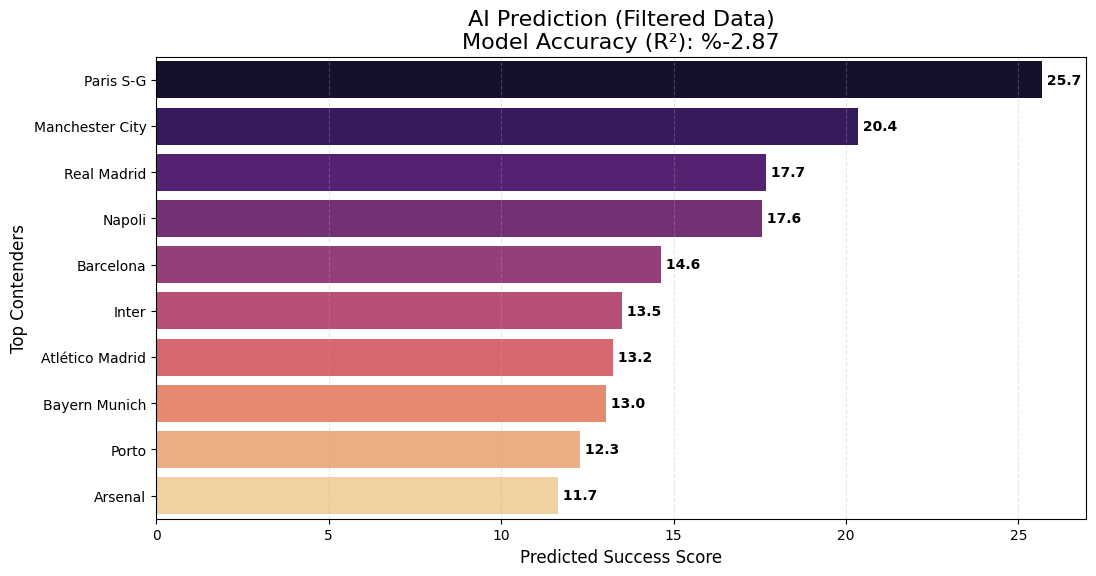

/tmp/ipython-input-754400507.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


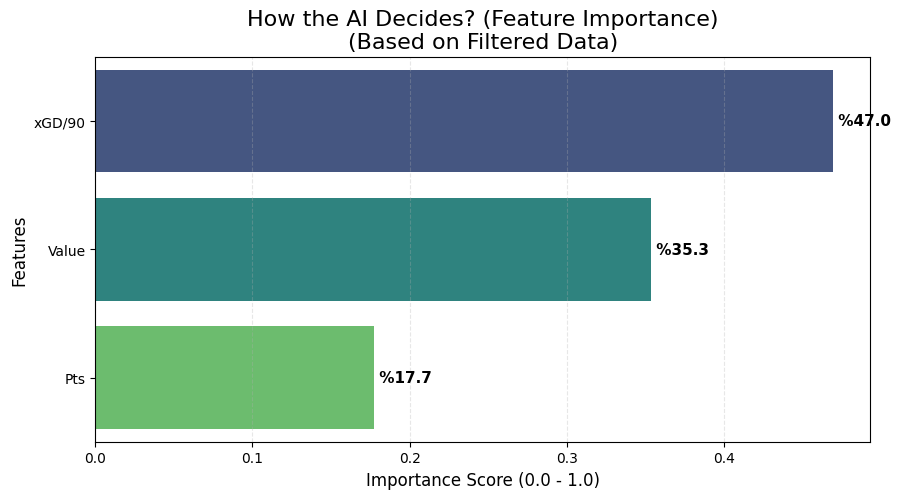

------------------------------------------------------------
🧠 AI ANALYSIS REPORT (FILTERED DATA)
------------------------------------------------------------
Prediction Accuracy (R²): %-2.87
------------------------------------------------------------
FEATURE IMPORTANCE RANKING:
👉 xGD/90         : %46.96
👉 Value          : %35.33
👉 Pts            : %17.71
------------------------------------------------------------
INTERPRETATION:
⚽ The model suggests: QUALITY OF PLAY (xGD) is what really matters.
------------------------------------------------------------


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. DATA PREPARATION & FILTERING
# Ana veriyi kopyala
df_rf = full_data.copy()

# --- FILTERING STEP ---
# Remove teams where eliminated is 0
if 'Eliminated' in df_rf.columns:
    initial_count = len(df_rf)
    df_rf = df_rf[df_rf['Eliminated'] != 0]
    final_count = len(df_rf)

    print("-" * 60)
    print("🧹 DATA CLEANING REPORT")
    print("-" * 60)
    print(f"Total Rows Before Filter : {initial_count}")
    print(f"Total Rows After Filter  : {final_count}")
    print(f"Rows Dropped (Eliminated=0): {initial_count - final_count}")
    print("-" * 60)
else:
    print("WARNING: 'eliminated' column not found. No filtering applied.")

# 2. TIME MACHINE SPLIT (Train: Past, Test: 2023-2024)
features = ['Pts', 'Value', 'xGD/90']

train_data = df_rf[df_rf['Season'] != '2023-2024'].copy()
test_data = df_rf[df_rf['Season'] == '2023-2024'].copy()

# Güvenlik önlemi: Eğer filtreleme sonrası 2023-2024 verisi kalmadıysa son sezonu al
if len(test_data) == 0:
    print("⚠️ WARNING: 2023-2024 data missing after filtering. Using the latest available season.")
    last_season = df_rf['Season'].max()
    test_data = df_rf[df_rf['Season'] == last_season].copy()
    train_data = df_rf[df_rf['Season'] != last_season].copy()

# 3. TRAIN RANDOM FOREST MODEL
X_train = train_data[features]
y_train = train_data['Success_Score']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. PREDICT & EVALUATE
X_test = test_data[features]
y_test_actual = test_data['Success_Score']

# Tahmin yap
test_data['Predicted_Score'] = rf_model.predict(X_test)
prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

# Sıralama (En yüksek tahmin edilen ilk 10)
champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

# =======================================================
# PLOT 1: PREDICTION RANKING (Filtered Data)
# =======================================================
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Predicted_Score',
    y='Squad',
    data=champions_prediction,
    palette='magma'
)
plt.title(f'AI Prediction (Filtered Data)\nModel Accuracy (R²): %{prediction_r2*100:.2f}', fontsize=16)
plt.xlabel('Predicted Success Score', fontsize=12)
plt.ylabel('Top Contenders', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Değerleri çubuklara yaz
for index, value in enumerate(champions_prediction['Predicted_Score']):
    plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

plt.show()

# =======================================================
# PLOT 2: FEATURE IMPORTANCE (Filtered Data)
# =======================================================
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('How the AI Decides? (Feature Importance)\n(Based on Filtered Data)', fontsize=16)
plt.xlabel('Importance Score (0.0 - 1.0)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f' %{value*100:.1f}', va='center', fontweight='bold', fontsize=11)

plt.show()

# =======================================================
# CONSOLE REPORT
# =======================================================
print("-" * 60)
print("🧠 AI ANALYSIS REPORT (FILTERED DATA)")
print("-" * 60)
print(f"Prediction Accuracy (R²): %{prediction_r2*100:.2f}")
print("-" * 60)
print("FEATURE IMPORTANCE RANKING:")
for index, row in feature_importance_df.iterrows():
    print(f"👉 {row['Feature']:<15}: %{row['Importance']*100:.2f}")
print("-" * 60)

# Yorumlama Mantığı
top_feature = feature_importance_df.iloc[0]['Feature']
print("INTERPRETATION:")
if top_feature == 'Value':
    print("💰 The model suggests: MONEY is the biggest factor for success.")
elif top_feature == 'Pts':
    print("📈 The model suggests: GROUP PERFORMANCE (Points) is the key filter.")
    print("   (Teams with low group points rarely succeed in knockout stages.)")
elif top_feature == 'xGD/90':
    print("⚽ The model suggests: QUALITY OF PLAY (xGD) is what really matters.")
print("-" * 60)

/tmp/ipython-input-3434947358.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


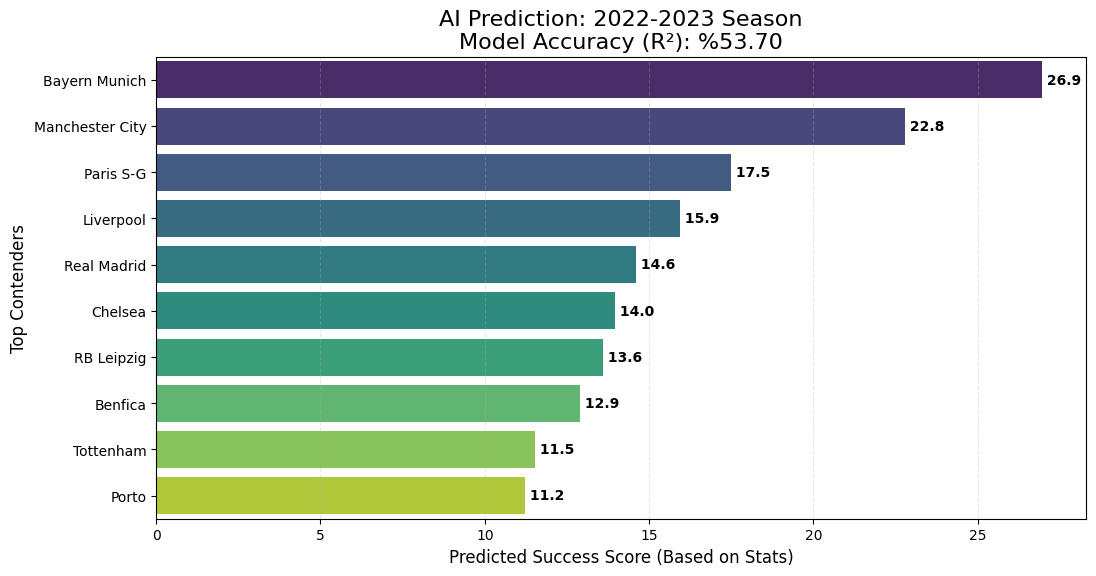

------------------------------------------------------------
🏆 AI PREDICTION RESULTS FOR 2022-2023
------------------------------------------------------------
Rank  Team                 M. Value (€)    Predicted Score
------------------------------------------------------------
1     Bayern Munich        870.0           26.95          
2     Manchester City      1050.0          22.79          
3     Paris S-G            890.0           17.50          
4     Liverpool            930.0           15.94          
5     Real Madrid          830.0           14.59          
6     Chelsea              860.0           13.96          
7     RB Leipzig           480.0           13.60          
8     Benfica              250.0           12.89          
9     Tottenham            685.0           11.52          
10    Porto                260.0           11.21          
------------------------------------------------------------
REALITY CHECK: The actual winner of 2022-2023 was MANCHESTER CITY.
If

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# ==========================================
# CONFIGURATION: TIME MACHINE SETTINGS
# ==========================================
TARGET_SEASON = '2022-2023'  # We are traveling to this year
features = ['Pts', 'Value', 'xGD/90']

# 1. DATA PREPARATION
# Train on everything EXCEPT the target season
train_data = full_data[full_data['Season'] != TARGET_SEASON].copy()
# Test ON the target season
test_data = full_data[full_data['Season'] == TARGET_SEASON].copy()

# Error Check
if len(test_data) == 0:
    print(f"ERROR: Season '{TARGET_SEASON}' not found in the dataset!")
else:
    # 2. TRAIN THE MODEL (Random Forest - Week 9)
    X_train = train_data[features]
    y_train = train_data['Success_Score']

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 3. PREDICT & EVALUATE
    X_test = test_data[features]
    y_test_actual = test_data['Success_Score'] # Actual results of 22-23

    # AI Prediction
    test_data['Predicted_Score'] = rf_model.predict(X_test)

    # Calculate Accuracy (R²) for this specific season
    prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

    # 4. RANKING
    champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

    # -------------------------------------------------------
    # VISUALIZATION
    # -------------------------------------------------------
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='Predicted_Score',
        y='Squad',
        data=champions_prediction,
        palette='viridis' # Changed color to distinguish from previous plot
    )

    plt.title(f'AI Prediction: {TARGET_SEASON} Season\nModel Accuracy (R²): %{prediction_r2*100:.2f}', fontsize=16)
    plt.xlabel('Predicted Success Score (Based on Stats)', fontsize=12)
    plt.ylabel('Top Contenders', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    # Add labels
    for index, value in enumerate(champions_prediction['Predicted_Score']):
        plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

    plt.show()

    # -------------------------------------------------------
    # CONSOLE REPORT
    # -------------------------------------------------------
    print("-" * 60)
    print(f"🏆 AI PREDICTION RESULTS FOR {TARGET_SEASON}")
    print("-" * 60)
    print(f"{'Rank':<5} {'Team':<20} {'M. Value (€)':<15} {'Predicted Score':<15}")
    print("-" * 60)

    for i, (index, row) in enumerate(champions_prediction.iterrows(), 1):
        print(f"{i:<5} {row['Squad']:<20} {row['Value']:<15.1f} {row['Predicted_Score']:<15.2f}")

    print("-" * 60)
    print(f"REALITY CHECK: The actual winner of {TARGET_SEASON} was MANCHESTER CITY.")
    print("If Man City is #1 here, your model is perfectly aligned with reality.")
    print("-" * 60)

/tmp/ipython-input-1419944488.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


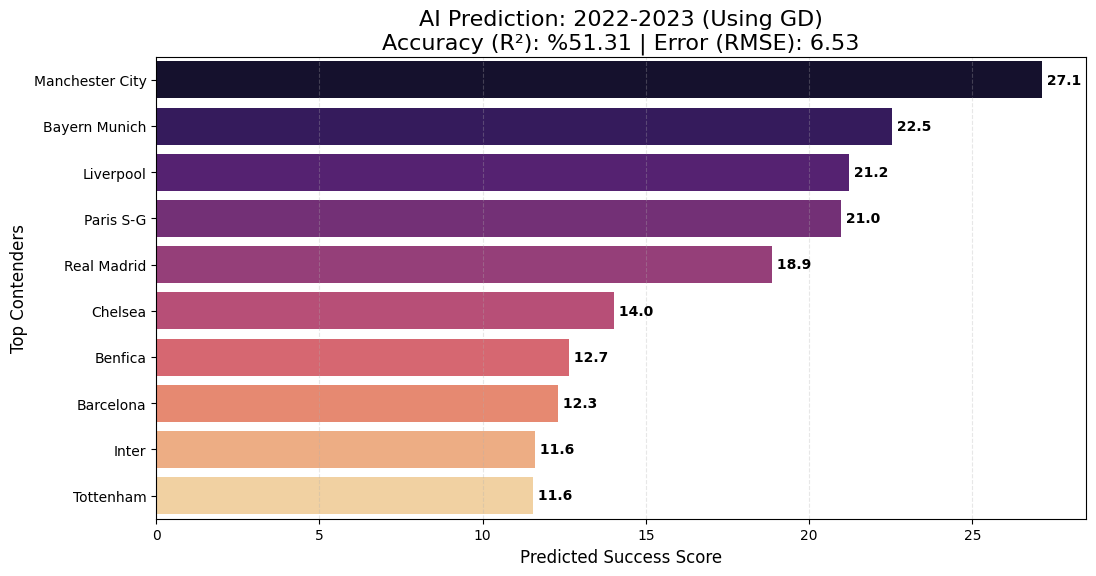

/tmp/ipython-input-1419944488.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


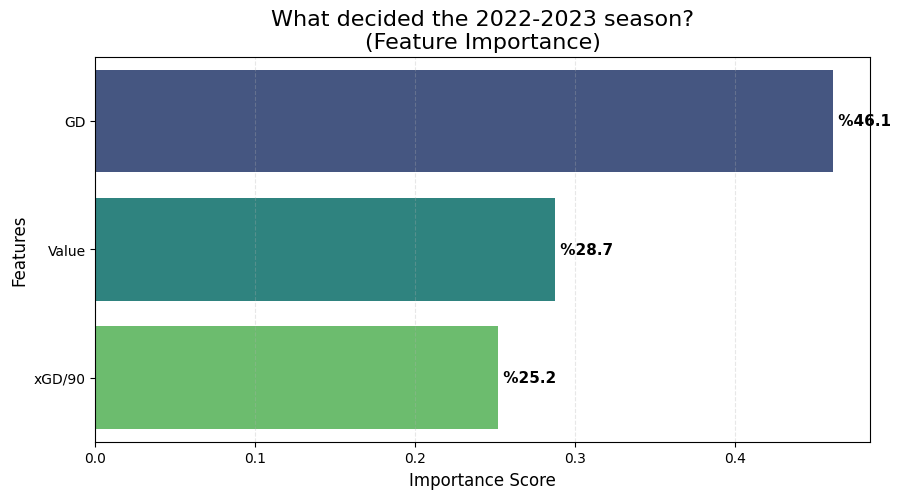

------------------------------------------------------------
🏆 AI ANALYSIS FOR 2022-2023
------------------------------------------------------------
Model Accuracy (R²): %51.31
Prediction Error (RMSE): 6.53
 > (RMSE indicates the average point deviation from reality)
------------------------------------------------------------
FEATURE IMPORTANCE:
👉 GD        : %46.12
👉 Value     : %28.72
👉 xGD/90    : %25.16
------------------------------------------------------------
PREDICTED TOP 5:
          Squad  Predicted_Score
Manchester City            27.13
  Bayern Munich            22.53
      Liverpool            21.23
      Paris S-G            20.97
    Real Madrid            18.85
------------------------------------------------------------
INTERPRETATION:
🥅 The model relied heavily on GOAL DIFFERENCE.
   It implies that dominant wins were the key to that season.
------------------------------------------------------------


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ==========================================
# 0. DATA CLEANING & PREPARATION
# ==========================================
# Ana veriyi kopyala
df_rf = full_data.copy()

# 'GD' (Averaj) sütununu sayıya çevir (Hata riskine karşı)
df_rf['GD'] = pd.to_numeric(df_rf['GD'], errors='coerce')

# Sayıya çevirince problem çıkan (boş) satırları temizle
df_rf = df_rf.dropna(subset=['GD', 'Value', 'xGD/90', 'Success_Score'])

# ==========================================
# 1. CONFIGURATION
# ==========================================
TARGET_SEASON = '2022-2023'  # Zaman makinesi bu yıla gidiyor
features = ['GD', 'Value', 'xGD/90'] # Pts yerine GD var

# Train on everything EXCEPT the target season
train_data = df_rf[df_rf['Season'] != TARGET_SEASON].copy()
# Test ON the target season
test_data = df_rf[df_rf['Season'] == TARGET_SEASON].copy()

# Hata Kontrolü
if len(test_data) == 0:
    print(f"ERROR: Season '{TARGET_SEASON}' not found in the dataset!")
else:
    # 2. TRAIN THE MODEL (Random Forest)
    X_train = train_data[features]
    y_train = train_data['Success_Score']

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # 3. PREDICT & EVALUATE
    X_test = test_data[features]
    y_test_actual = test_data['Success_Score']

    # AI Prediction
    test_data['Predicted_Score'] = rf_model.predict(X_test)

    # METRICS (R² and RMSE)
    prediction_r2 = r2_score(y_test_actual, test_data['Predicted_Score'])

    mse = mean_squared_error(y_test_actual, test_data['Predicted_Score'])
    rmse = np.sqrt(mse)

    # 4. RANKING
    champions_prediction = test_data.sort_values(by='Predicted_Score', ascending=False).head(10)

    # -------------------------------------------------------
    # PLOT 1: PREDICTION RANKING
    # -------------------------------------------------------
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='Predicted_Score',
        y='Squad',
        data=champions_prediction,
        palette='magma'
    )

    plt.title(f'AI Prediction: {TARGET_SEASON} (Using GD)\nAccuracy (R²): %{prediction_r2*100:.2f} | Error (RMSE): {rmse:.2f}', fontsize=16)
    plt.xlabel('Predicted Success Score', fontsize=12)
    plt.ylabel('Top Contenders', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    for index, value in enumerate(champions_prediction['Predicted_Score']):
        plt.text(value, index, f' {value:.1f}', va='center', fontweight='bold')

    plt.show()

    # -------------------------------------------------------
    # PLOT 2: FEATURE IMPORTANCE
    # -------------------------------------------------------
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=feature_importance_df,
        palette='viridis'
    )

    plt.title(f'What decided the {TARGET_SEASON} season?\n(Feature Importance)', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    for index, value in enumerate(feature_importance_df['Importance']):
        plt.text(value, index, f' %{value*100:.1f}', va='center', fontweight='bold', fontsize=11)

    plt.show()

    # -------------------------------------------------------
    # CONSOLE REPORT
    # -------------------------------------------------------
    print("-" * 60)
    print(f"🏆 AI ANALYSIS FOR {TARGET_SEASON}")
    print("-" * 60)
    print(f"Model Accuracy (R²): %{prediction_r2*100:.2f}")
    print(f"Prediction Error (RMSE): {rmse:.2f}")
    print(" > (RMSE indicates the average point deviation from reality)")
    print("-" * 60)
    print("FEATURE IMPORTANCE:")
    for index, row in feature_importance_df.iterrows():
        print(f"👉 {row['Feature']:<10}: %{row['Importance']*100:.2f}")
    print("-" * 60)
    print("PREDICTED TOP 5:")
    print(champions_prediction[['Squad', 'Predicted_Score']].head(5).to_string(index=False))
    print("-" * 60)

    # Yorumlama
    top_feature = feature_importance_df.iloc[0]['Feature']
    print("INTERPRETATION:")
    if top_feature == 'GD':
        print("🥅 The model relied heavily on GOAL DIFFERENCE.")
        print("   It implies that dominant wins were the key to that season.")
    elif top_feature == 'Value':
        print("💰 The model relied heavily on MARKET VALUE.")
        print("   It implies that squad depth/budget was the deciding factor.")
    print("-" * 60)

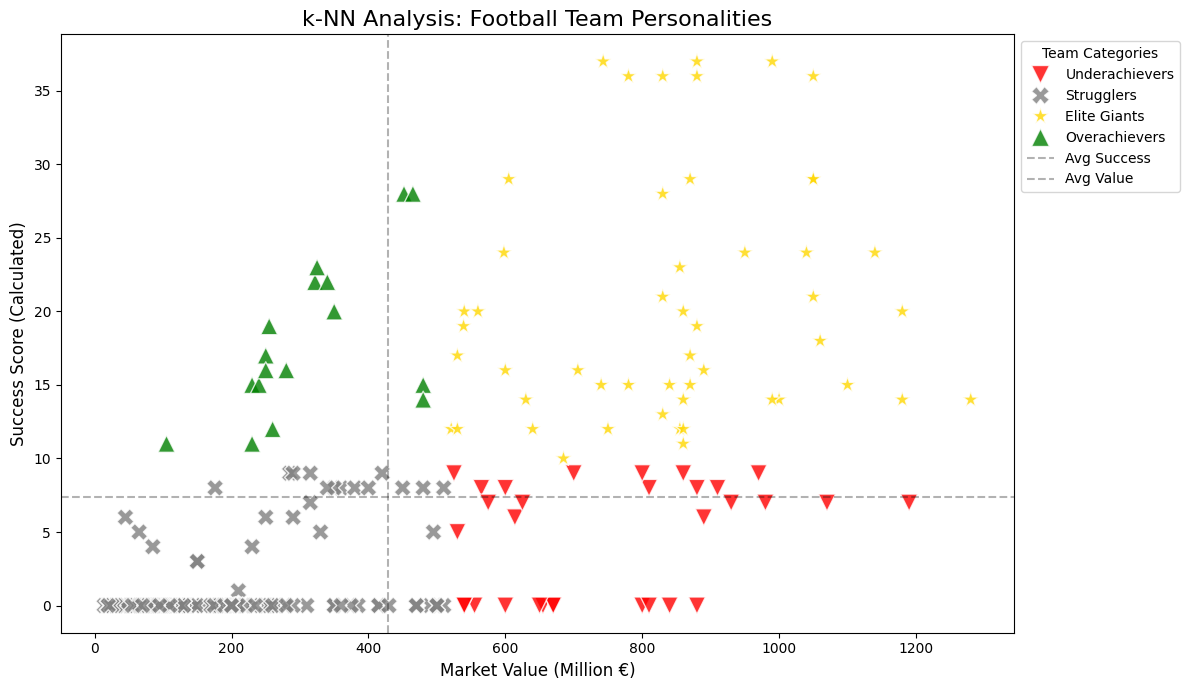

--------------------------------------------------------------------------------
🏆 k-NN CLASSIFICATION RESULTS (SAMPLE TEAMS)
--------------------------------------------------------------------------------
   Season           Squad  Value  Success_Score       Category
2019-2020   Bayern Munich    880             36   Elite Giants
2020-2021       Liverpool   1000             14   Elite Giants
2018-2019 Manchester City   1060             18   Elite Giants
2017-2018       Barcelona    706             16   Elite Giants
2022-2023           Milan    560             20   Elite Giants
2019-2020        Atalanta    250             17  Overachievers
2022-2023         Benfica    250             16  Overachievers
2021-2022         Benfica    280             16  Overachievers
2023-2024      RB Leipzig    480             14  Overachievers
2020-2021           Porto    255             19  Overachievers
2022-2023        Shakhtar     80              0     Strugglers
2023-2024           Lazio    285     

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# 1. DATA PREPARATION
df_knn = full_data.copy()
X = df_knn[['Value', 'Success_Score']]

# Scale the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. k-NN TRAINING (DEFINING ARCHETYPES)
X_train_archetypes = np.array([
    [ 1.5,  1.5],  # High Value, High Success
    [ 1.5, -1.0],  # High Value, Low Success
    [-1.0,  1.5],  # Low Value,  High Success
    [-1.0, -1.0]   # Low Value,  Low Success
])

# LABELS (Emoji REMOVED to fix the error)
y_train_labels = [
    'Elite Giants',       # Zengin ve Başarılı
    'Underachievers',     # Balon Takımlar
    'Overachievers',      # Sürpriz Takımlar
    'Strugglers'          # Zorlananlar
]

# Initialize k-NN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_archetypes, y_train_labels)

# 3. CLASSIFY ALL TEAMS
predicted_categories = knn.predict(X_scaled)
df_knn['Category'] = predicted_categories

# 4. CREATE A SAMPLE TABLE
final_table = pd.DataFrame()
for category in y_train_labels:
    if len(df_knn[df_knn['Category'] == category]) > 0:
        subset = df_knn[df_knn['Category'] == category].sample(5, replace=True)
        final_table = pd.concat([final_table, subset])

display_cols = ['Season', 'Squad', 'Value', 'Success_Score', 'Category']
final_table = final_table[display_cols].sort_values(by='Category')

# 5. VISUALIZATION (Fixed Markers)
plt.figure(figsize=(12, 7))

# Define shapes for each category (Meaningful markers)
# Elite -> Star (*), Under -> Down Triangle (v), Over -> Up Triangle (^), Struggle -> X (X)
markers_dict = {
    'Elite Giants': '*',
    'Underachievers': 'v',
    'Overachievers': '^',
    'Strugglers': 'X'
}

sns.scatterplot(
    data=df_knn,
    x='Value',
    y='Success_Score',
    hue='Category',
    style='Category',   # This enables different shapes
    markers=markers_dict, # Assigning our custom shapes
    palette={
        'Elite Giants': 'gold',
        'Underachievers': 'red',
        'Overachievers': 'green',
        'Strugglers': 'gray'
    },
    s=150, # Make points slightly bigger
    alpha=0.8
)

# Reference lines
plt.axhline(df_knn['Success_Score'].mean(), color='black', linestyle='--', alpha=0.3, label='Avg Success')
plt.axvline(df_knn['Value'].mean(), color='black', linestyle='--', alpha=0.3, label='Avg Value')

plt.title('k-NN Analysis: Football Team Personalities', fontsize=16)
plt.xlabel('Market Value (Million €)', fontsize=12)
plt.ylabel('Success Score (Calculated)', fontsize=12)
plt.legend(title='Team Categories', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# 6. PRINT RESULTS TO CONSOLE
print("-" * 80)
print("🏆 k-NN CLASSIFICATION RESULTS (SAMPLE TEAMS)")
print("-" * 80)
print(final_table.to_string(index=False))
print("-" * 80)

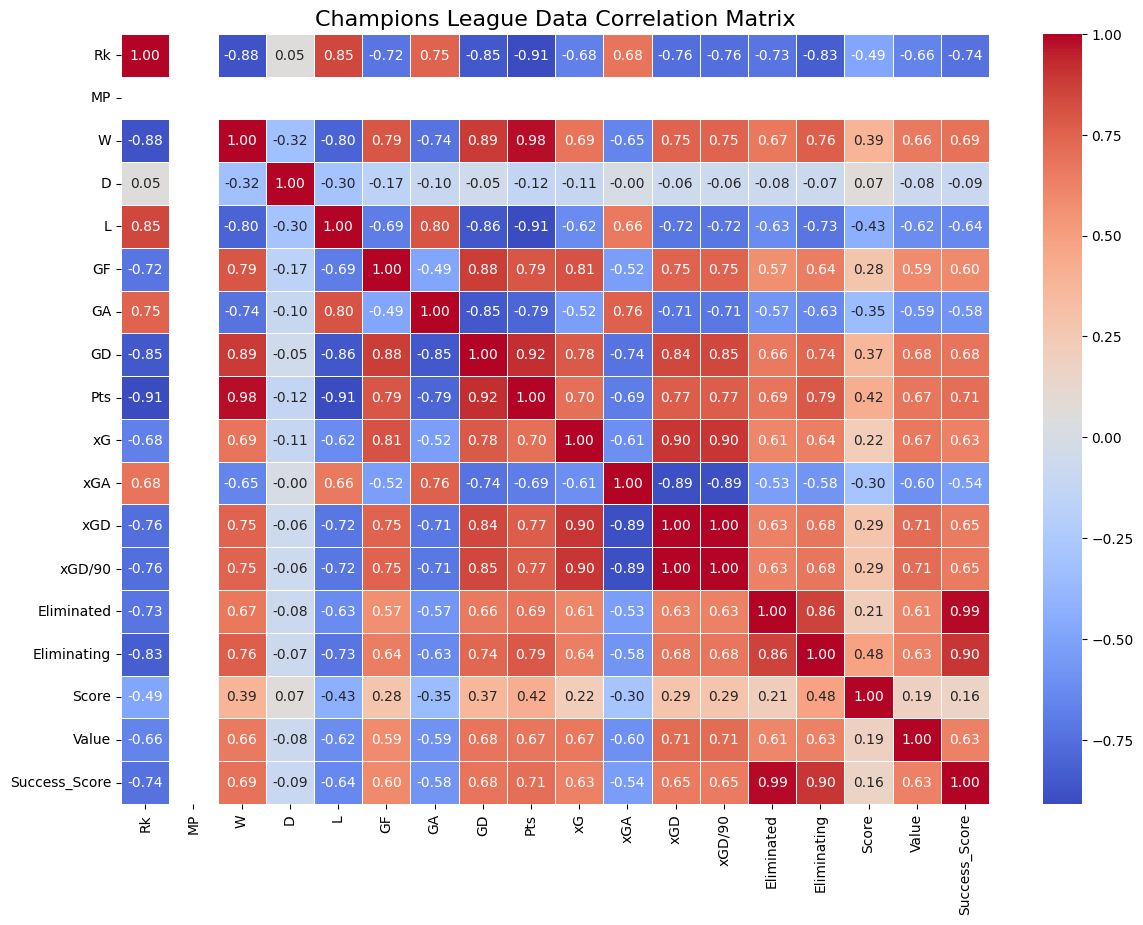

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Veriyi Yükleme (Excel formatı için düzeltme)
file_path = 'Champions_League_All_Years_Cleaned.xlsx'
df = pd.read_excel(file_path) # Burayı read_excel olarak değiştirdik

# 2. Sayısal Olmayan Sütunları Çıkarma
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# 3. Korelasyon Matrisini Hesaplama
corr_matrix = numeric_df.corr()

# 4. Isı Haritası (Heatmap)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Champions League Data Correlation Matrix', fontsize=16)
plt.show()

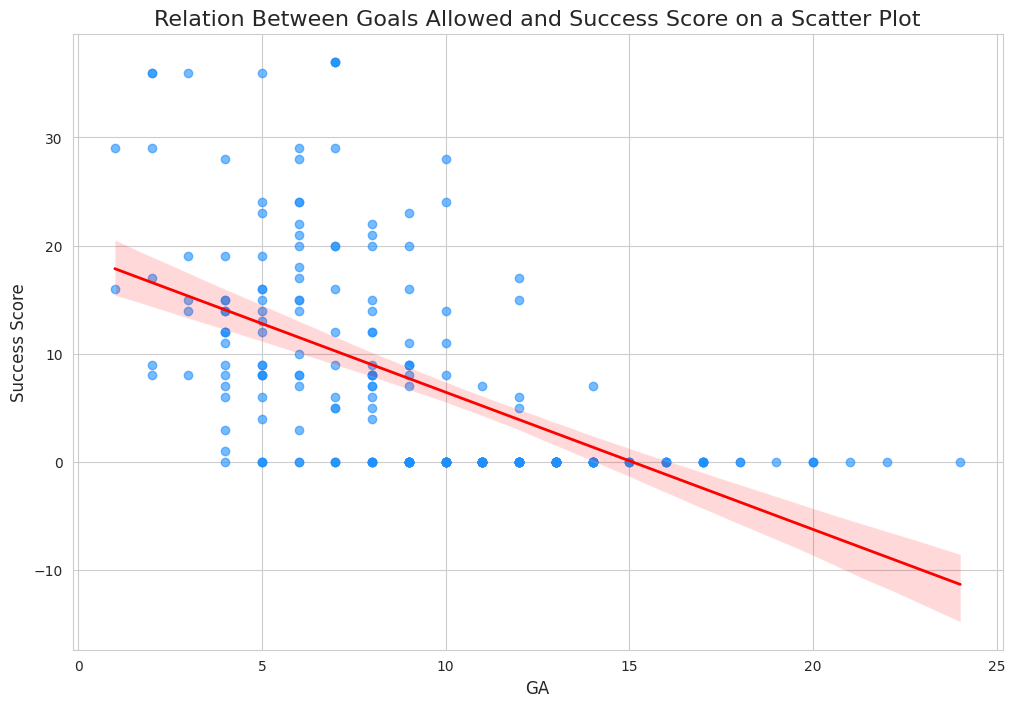

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Veriyi Yükleme
# Dosya uzantısı .xlsx olduğu için 'read_excel' kullanıyoruz.
file_path = 'Champions_League_All_Years_Cleaned.xlsx'

# Eğer bu satırda hata alırsan, terminale 'pip install openpyxl' yazıp kütüphaneyi yüklemen gerekebilir.
df = pd.read_excel(file_path)

# 2. Grafik Ayarları
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid") # Okunabilirliği artırmak için ızgara ekledik

# 3. Scatter Plot ve Regresyon Doğrusu
# x: Yenen Gol (GA), y: Başarı Skoru
sns.regplot(
    data=df,
    x='GA',
    y='Success_Score',
    scatter_kws={'alpha': 0.6, 'color': 'dodgerblue'}, # Noktaların rengi ve şeffaflığı
    line_kws={'color': 'red', 'linewidth': 2} # Kırmızı trend çizgisi
)

# 4. Başlık ve Eksen İsimleri
plt.title('Relation Between Goals Allowed and Success Score on a Scatter Plot', fontsize=16)
plt.xlabel('GA', fontsize=12)
plt.ylabel('Success Score', fontsize=12)

# 5. Grafiği Göster
plt.show()

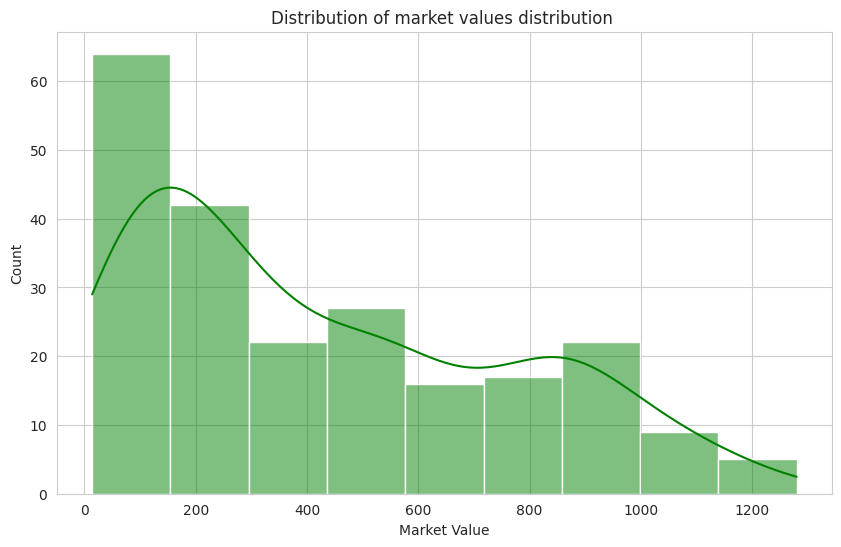

In [21]:
# Takım Değerlerinin Dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['Value'], kde=True, color='green')
plt.title('Distribution of market values distribution ')
plt.xlabel('Market Value')
plt.show()

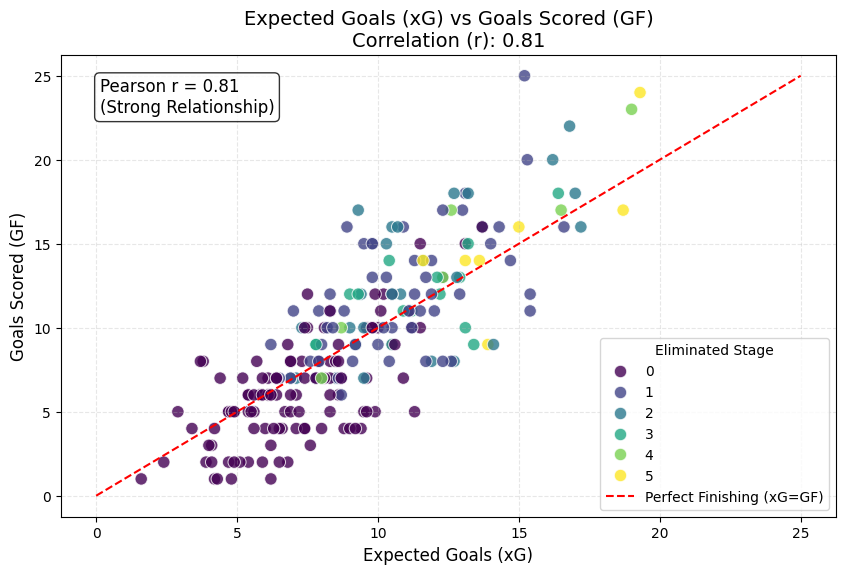

--------------------------------------------------
📊 İSTATİSTİKSEL İLİŞKİ ANALİZİ
--------------------------------------------------
Pearson Korelasyon Katsayısı (r): 0.8132
P-Değeri (p-value)              : 4.2947e-54
--------------------------------------------------
✅ SONUÇ: İstatistiksel olarak ANLAMLI bir ilişki var.
   Yani xG arttıkça gol sayısı da tesadüf değil, matematiksel bir kesinlikle artıyor.
--------------------------------------------------


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. VERİ HAZIRLIĞI (Garanti olsun diye sayısal kontrol)
# df yerine full_data kullanıyorsan burayı full_data yapabilirsin.
df_corr = full_data.copy()

cols = ['xG', 'GF']
for col in cols:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

# NaN (Boş) değerleri atıyoruz yoksa hata verir
df_corr = df_corr.dropna(subset=cols)

# 2. PEARSON KORELASYON HESABI
# r: Korelasyon katsayısı (-1 ile 1 arası)
# p_value: İstatistiksel anlamlılık (0.05'ten küçükse ilişki tesadüf değildir)
r_value, p_value = stats.pearsonr(df_corr['xG'], df_corr['GF'])

# 3. GÖRSELLEŞTİRME
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_corr, x='xG', y='GF', hue='Eliminated', palette='viridis', alpha=0.8, s=80)

# Referans Çizgisi (xG = GF)
max_val = max(df_corr['xG'].max(), df_corr['GF'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Finishing (xG=GF)')

plt.title(f'Expected Goals (xG) vs Goals Scored (GF)\nCorrelation (r): {r_value:.2f}', fontsize=14)
plt.xlabel('Expected Goals (xG)', fontsize=12)
plt.ylabel('Goals Scored (GF)', fontsize=12)
plt.legend(title='Eliminated Stage')
plt.grid(True, linestyle='--', alpha=0.3)

# 4. GRAFİK ÜZERİNE METİN EKLEME
# Grafiğin sol üst köşesine istatistikleri yazalım
text_str = f'Pearson r = {r_value:.2f}\n(Strong Relationship)' if r_value > 0.7 else f'Pearson r = {r_value:.2f}\n(Moderate Relationship)'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# 5. KONSOL ÇIKTISI
print("-" * 50)
print("📊 İSTATİSTİKSEL İLİŞKİ ANALİZİ")
print("-" * 50)
print(f"Pearson Korelasyon Katsayısı (r): {r_value:.4f}")
print(f"P-Değeri (p-value)              : {p_value:.4e}") # Bilimsel gösterim
print("-" * 50)
if p_value < 0.05:
    print("✅ SONUÇ: İstatistiksel olarak ANLAMLI bir ilişki var.")
    print("   Yani xG arttıkça gol sayısı da tesadüf değil, matematiksel bir kesinlikle artıyor.")
else:
    print("❌ SONUÇ: İstatistiksel olarak anlamlı bir ilişki YOK.")
print("-" * 50)

In [18]:
# Underdogs
df['Value_Z'] = (df['Value'] - df['Value'].mean()) / df['Value'].std()
df['Pts_Z'] = (df['Pts'] - df['Pts'].mean()) / df['Pts'].std()

# low market value
underdogs = df[(df['Value_Z'] < -0.5) & (df['Pts_Z'] > 1)]
print(underdogs[['Season', 'Squad', 'Value', 'Pts', 'Success_Score']])

        Season     Squad  Value  Pts  Success_Score
24   2017-2018  Beşiktaş     85   14              4
44   2018-2019     Porto    240   16             15
188  2022-2023   Benfica    250   14             16


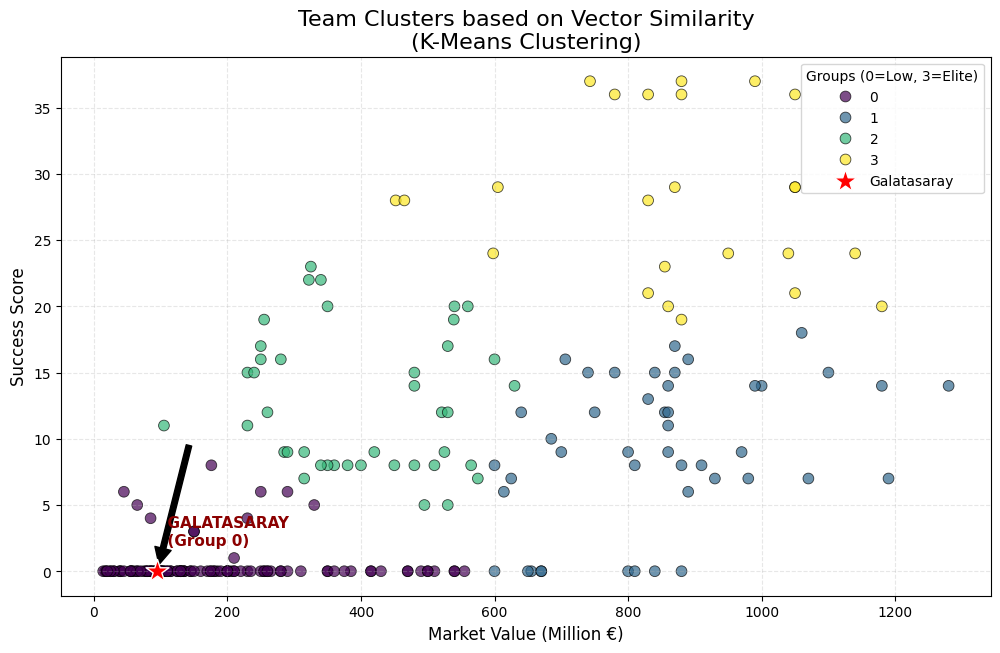

------------------------------------------------------------
🦁 GALATASARAY ANALİZİ
------------------------------------------------------------
Bulunduğu Grup: 0 (0 en kötü, 3 en iyi)
Değeri        : 95 M€
Başarısı      : 0
------------------------------------------------------------
GALATASARAY İLE AYNI GRUPTA OLAN DİĞER TAKIMLAR (Benzerleri):
 > APOEL FC
 > Atlético Madrid
 > RB Leipzig
 > Marseille
 > Inter
------------------------------------------------------------


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# 1. VERİ HAZIRLIĞI
df_cluster = full_data.copy()

# Temizlik ve Sayısal Dönüşüm
cols = ['Value', 'Success_Score']
for col in cols:
    df_cluster[col] = pd.to_numeric(df_cluster[col], errors='coerce')
df_cluster = df_cluster.dropna(subset=cols).reset_index(drop=True)

# 2. NORMALİZASYON (Vektörel Uzaklık İçin Çok Önemli)
# Para (Milyon €) ile Puan (0-100) arasındaki ölçek farkını yok ediyoruz.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_cluster[cols])

# 3. K-MEANS CLUSTERING (Otomatik Gruplandırma)
# Takımları 4 gruba ayıralım (Örn: Elitler, İyi Orta Sıra, Düşük Bütçeli Başarılılar, Zayıflar)
# Algoritma, birbirine "vektörel olarak" en yakın takımları aynı kümeye koyar.
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['Cluster_ID'] = kmeans.fit_predict(X_scaled)

# Kümeleri isimlendiremeyiz (0,1,2,3 deriz) ama başarı ortalamasına göre sıralayabiliriz
# Böylece en yüksek puanlı grup her zaman belli bir renk olur.
cluster_means = df_cluster.groupby('Cluster_ID')['Success_Score'].mean().sort_values()
cluster_mapping = {old_id: new_id for new_id, old_id in enumerate(cluster_means.index)}
df_cluster['Cluster_Label'] = df_cluster['Cluster_ID'].map(cluster_mapping)
# Artık 3 numara en iyiler, 0 numara en zayıflar.

# 4. GALATASARAY'I BUL
target_team = "Galatasaray"
gs_data = df_cluster[df_cluster['Squad'].str.contains(target_team, case=False, na=False)]

# 5. GÖRSELLEŞTİRME
plt.figure(figsize=(12, 7))

# A) Tüm Takımlar (Gruplara Göre Renkli)
# 'viridis' paleti kullandım: Sarı/Yeşil en iyiler, Mor en zayıflar olur.
scatter = sns.scatterplot(
    data=df_cluster,
    x='Value',
    y='Success_Score',
    hue='Cluster_Label',
    palette='viridis',
    s=60,
    alpha=0.7,
    edgecolor='black'
)

# B) SADECE GALATASARAY'I İŞARETLE
if not gs_data.empty:
    gs_x = gs_data.iloc[0]['Value']
    gs_y = gs_data.iloc[0]['Success_Score']
    gs_cluster = gs_data.iloc[0]['Cluster_Label']

    # Kırmızı Çerçeveli Büyük Bir Nokta Koy
    plt.scatter(gs_x, gs_y, s=300, color='red', marker='*', edgecolors='white', zorder=10, label='Galatasaray')

    # İsmini Yaz (Hafif yukarıya)
    plt.text(gs_x, gs_y + 2, f"  GALATASARAY\n  (Group {gs_cluster})",
             fontsize=11, fontweight='bold', color='darkred', zorder=11)

    # Ok İşareti (Opsiyonel havalı durur)
    plt.annotate('', xy=(gs_x, gs_y), xytext=(gs_x + 50, gs_y + 10),
                 arrowprops=dict(facecolor='black', shrink=0.05))

else:
    print(f"UYARI: '{target_team}' veri setinde bulunamadı!")

# Grafik Ayarları
plt.title('Team Clusters based on Vector Similarity\n(K-Means Clustering)', fontsize=16)
plt.xlabel('Market Value (Million €)', fontsize=12)
plt.ylabel('Success Score', fontsize=12)

# Legend'ı düzenle
handles, labels = scatter.get_legend_handles_labels()
labels = ['Tier 4 (Lowest)', 'Tier 3', 'Tier 2', 'Tier 1 (Elite)'] # Etiketleri biz uydurduk
# plt.legend(handles, labels, title="Performance Groups") # Bazen hata verebilir, basit tutalım:
plt.legend(title="Groups (0=Low, 3=Elite)")

plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 6. GRUP ANALİZİ RAPORU
if not gs_data.empty:
    print("-" * 60)
    print(f"🦁 GALATASARAY ANALİZİ")
    print("-" * 60)
    print(f"Bulunduğu Grup: {gs_cluster} (0 en kötü, 3 en iyi)")
    print(f"Değeri        : {gs_x} M€")
    print(f"Başarısı      : {gs_y}")
    print("-" * 60)
    print(f"GALATASARAY İLE AYNI GRUPTA OLAN DİĞER TAKIMLAR (Benzerleri):")
    # Aynı gruptan rastgele 5 takım göster
    peers = df_cluster[df_cluster['Cluster_Label'] == gs_cluster]['Squad'].sample(5).values
    for peer in peers:
        print(f" > {peer}")
    print("-" * 60)

-----------------------------------------------------------------
SEASON          R² SCORE (Accuracy)       RMSE (Error Margin) 
-----------------------------------------------------------------
2017-2018       %54.84                    +/- 6.53
2018-2019       %41.52                    +/- 7.44
2019-2020       %19.55                    +/- 8.41
2020-2021       %57.58                    +/- 6.23
2021-2022       %39.12                    +/- 7.56
2022-2023       %51.31                    +/- 6.53
2023-2024       %57.80                    +/- 6.35
-----------------------------------------------------------------
🌍 Average R²  : %45.96
🌍 Average RMSE: 7.01
-----------------------------------------------------------------


/tmp/ipython-input-364967991.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


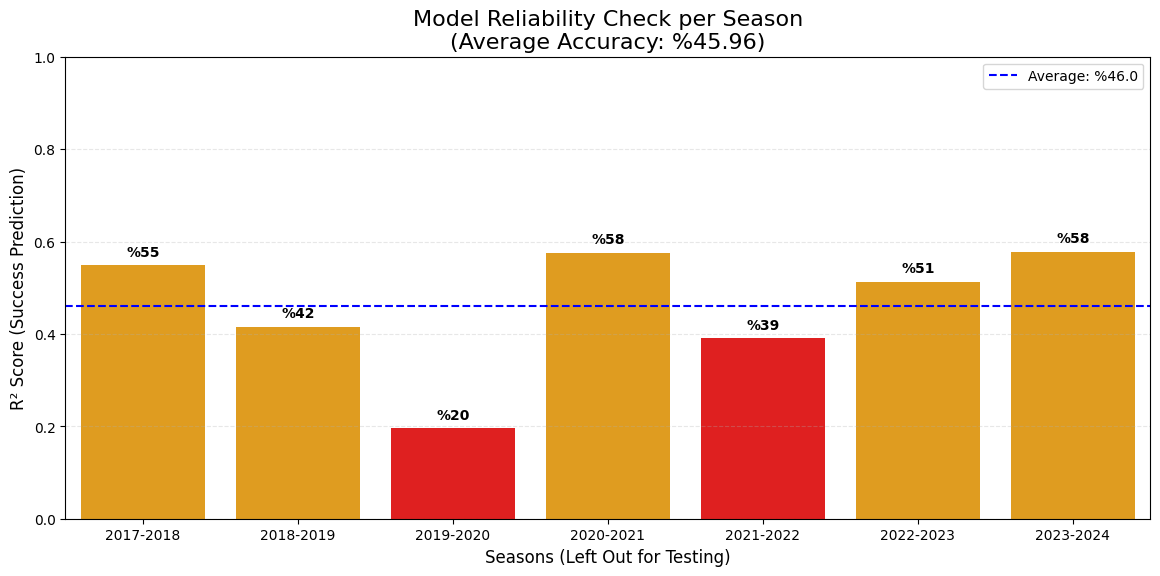


🤖 YORUM:
✅ En Kolay Tahmin Edilen Sezon: 2023-2024 (R²: %57.8)
   (Bu sezonda sürpriz az olmuş, istatistikler ve bütçe sonucu belirlemiş.)
⚠️ En Zor Tahmin Edilen Sezon  : 2019-2020 (R²: %19.5)
   (Bu sezonda muhtemelen çok fazla sürpriz oldu veya 'Leicester City' vakası yaşandı.)


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 1. VERİ HAZIRLIĞI
df_loop = full_data.copy()

# Temizlik
cols = ['GD', 'Value', 'xGD/90', 'Success_Score']
for col in cols:
    df_loop[col] = pd.to_numeric(df_loop[col], errors='coerce')

df_loop = df_loop.dropna(subset=cols)

# Özellikler (Puan yerine GD kullanıyoruz yine)
features = ['GD', 'Value', 'xGD/90']
target = 'Success_Score'

# Tüm sezonların listesini al
unique_seasons = df_loop['Season'].unique()
results = []

print("-" * 65)
print(f"{'SEASON':<15} {'R² SCORE (Accuracy)':<25} {'RMSE (Error Margin)':<20}")
print("-" * 65)

# 2. DÖNGÜ: HER SEZONU TEK TEK TEST ET
for season in sorted(unique_seasons):
    # A) Train/Test Split
    # Test: O anki döngüdeki sezon
    # Train: O sezon HARİÇ diğer tüm yıllar
    test_data = df_loop[df_loop['Season'] == season]
    train_data = df_loop[df_loop['Season'] != season]

    if len(test_data) < 5: # Çok az veri varsa atla
        continue

    # B) Modeli Eğit
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train_data[features], train_data[target])

    # C) Tahmin Yap
    preds = rf.predict(test_data[features])

    # D) Metrikleri Hesapla
    r2 = r2_score(test_data[target], preds)
    rmse = np.sqrt(mean_squared_error(test_data[target], preds))

    # Listeye kaydet
    results.append({
        'Season': season,
        'R2': r2,
        'RMSE': rmse
    })

    # Ekrana yaz
    print(f"{season:<15} %{r2*100:<24.2f} +/- {rmse:.2f}")

# 3. GENEL ANALİZ VE ORTALAMA
results_df = pd.DataFrame(results)
avg_r2 = results_df['R2'].mean()
avg_rmse = results_df['RMSE'].mean()

print("-" * 65)
print(f"🌍 Average R²  : %{avg_r2*100:.2f}")
print(f"🌍 Average RMSE: {avg_rmse:.2f}")
print("-" * 65)

# 4. GÖRSELLEŞTİRME (BAŞARI GRAFİĞİ)
plt.figure(figsize=(14, 6))

# Renk paleti: Başarısı yüksek olanlar yeşil, düşük olanlar kırmızı olsun
colors = ['green' if x > 0.6 else 'orange' if x > 0.4 else 'red' for x in results_df['R2']]

sns.barplot(
    x='Season',
    y='R2',
    data=results_df,
    palette=colors
)

plt.title(f'Model Reliability Check per Season\n(Average Accuracy: %{avg_r2*100:.2f})', fontsize=16)
plt.xlabel('Seasons (Left Out for Testing)', fontsize=12)
plt.ylabel('R² Score (Success Prediction)', fontsize=12)
plt.ylim(0, 1.0) # 0 ile 1 arası sabitleyelim
plt.axhline(y=avg_r2, color='blue', linestyle='--', label=f'Average: %{avg_r2*100:.1f}')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Çubukların üzerine değerleri yaz
for index, row in results_df.iterrows():
    plt.text(index, row['R2'] + 0.02, f"%{row['R2']*100:.0f}", ha='center', fontweight='bold')

plt.show()

# 5. YORUM
best_season = results_df.loc[results_df['R2'].idxmax()]
worst_season = results_df.loc[results_df['R2'].idxmin()]

print("\n🤖 YORUM:")
print(f"✅ En Kolay Tahmin Edilen Sezon: {best_season['Season']} (R²: %{best_season['R2']*100:.1f})")
print("   (Bu sezonda sürpriz az olmuş, istatistikler ve bütçe sonucu belirlemiş.)")
print(f"⚠️ En Zor Tahmin Edilen Sezon  : {worst_season['Season']} (R²: %{worst_season['R2']*100:.1f})")
print("   (Bu sezonda muhtemelen çok fazla sürpriz oldu veya 'Leicester City' vakası yaşandı.)")